### Hey Natalie,
#### This file should take you through picking metrics and then assessing the usefulness of the metrics chosen based on (in your case) a Kmeans clustering grouping.
#### Before you begin you must set the variable called extracted_path to the correct directory on your computer where you have the folders "S1 images (53 eyes)", "S2 images (35 eyes)" etc... including the "Extracted_and_expanded" generated by me.

In [10]:

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from IPython.display import clear_output
import matplotlib.colors as mcolors
import os
import cv2 # import computer vision
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
import pickle

# defin a function generate a neighborhood average image for each pixel in the image
def average_peripheral_neighborhood(img, n):
    # Prepare the resulting image container
    averaged_img = np.zeros_like(img)
    h, w = img.shape[0], img.shape[1]
    
    for y in range(h):
        for x in range(w):
            # List to gather the neighbors
            neighbors = []
            
            # Check the boundary and get the values of the peripheral neighbors
            for i in [-n, n]:
                if 0 <= y + i < h:
                    neighbors.append(img[y + i, x])
                if 0 <= x + i < w:
                    neighbors.append(img[y, x + i])
            
            # Calculate the average if there are any neighbors
            if neighbors:
                averaged_img[y, x] = np.mean(neighbors, axis=0)
            else:
                averaged_img[y, x] = img[y, x]
                
    return averaged_img

# define a function to generate a "megaimage" with the original image and the neighborhood average images
def makeMegaimage(RGBimg, HSVimg, n=3):
    imagecolumns = ['RGB: FAF', 'RGB: GREEN', 'RGB: IR', 'HSV: Hue', 'HSV: Saturation', 'HSV: Brightness']
    megaimage = np.zeros((RGBimg.shape[0], RGBimg.shape[1], 6+n*6), dtype=np.uint8)
    megaimage[:, :, 0:3] = RGBimg
    megaimage[:, :, 3:6] = HSVimg
    if n == 0:
        return megaimage
    for i in range(1, n+1):
        composite_RGBimg = average_peripheral_neighborhood(RGBimg, i)
        composite_HSVimg = average_peripheral_neighborhood(HSVimg, i)
        imagecolumns.append('RGB: FAF, n_hood={}'.format(i))
        imagecolumns.append('RGB: GREEN, n_hood={}'.format(i))
        imagecolumns.append('RGB: IR, n_hood={}'.format(i))
        imagecolumns.append('HSV: Hue, n_hood={}'.format(i))
        imagecolumns.append('HSV: Saturation, n_hood={}'.format(i))
        imagecolumns.append('HSV: Brightness, n_hood={}'.format(i))
        
        megaimage[:, :, 6*i:6*i+3] = composite_RGBimg
        megaimage[:, :, 6*i+3:6*i+6] = composite_HSVimg
    return megaimage, imagecolumns

# Split into train test dev
def split_train_test(files_path, random_seed_wanted = 42, train_ratio = 0.8, test_to_dev_ratio = 0.5):
    np.random.seed(random_seed_wanted)  # set random seed

    # make a random list of indices from files to split into train test dev
    possible_indices = np.arange(len(files_path))
    training_indices = np.random.choice(possible_indices, size=int(len(files_path)*train_ratio), replace=False)
    indicies_remaining = [i for i in possible_indices if i not in training_indices]
    test_indices = np.random.choice(indicies_remaining, size=int(len(indicies_remaining)*test_to_dev_ratio), replace=False)
    dev_indices = [i for i in indicies_remaining if i not in test_indices]

    print(f'length of training: {len(training_indices)} ratio = {len(training_indices)/len(possible_indices)*100:.2f}%; test: {len(test_indices)} ratio = {len(test_indices)/len(possible_indices)*100:.2f}%; dev: {len(dev_indices)} ratio = {len(dev_indices)/len(possible_indices)*100:.2f}%')
    print(np.sort(training_indices))
    print(np.sort(test_indices))
    print(np.sort(dev_indices))
    return training_indices, test_indices, dev_indices
    
# Function to generate a dataframe with the image data
def generate_CVS_holders(image_folder, image_folders, grader_folder, grader_folders, NeverranonthisPC = False):
    if not NeverranonthisPC:
        return None
    # The code below need not be run if you have already run it once or if you downloaded the companion csv files from the repository
    n_neighbors = 5

    # using n_neighbors, make a megaimage for each image in each folder
    for foldernumber in range(len(image_folders)):
        current_folder = image_folder + '\\' + image_folders[foldernumber]
        print(f'Working on {image_folders[foldernumber]}; {foldernumber+1}/{len(image_folders)}')
        for eye in ['OD', 'OS']:
            # open current folder to see contents
            current_images = os.listdir(current_folder)
            current_images = [i for i in current_images if 'preprocessed' in i]# throw out files that do not contain 'preprocessed'
            current_images = [i for i in current_images if eye in i] # get the relevant images for OD or OS eye
            if len(current_images) < 3:
                print(f'Not enough images in {current_folder}')
                continue
            # Get the OD grader
            grader_csv = f'{image_folders[foldernumber]} {eye}.csv'
            if grader_csv not in grader_folders: # check if the csv exists
                print(f'csv file {grader_csv} not found')
                continue

            grader_csv = pd.read_csv(grader_folder + '\\' + grader_csv)# open the csv as a dataframe
            grader_csv[['X', 'Y']] = grader_csv['X,Y'].str.split(',', expand=True)# split the X, Y coordinates into two columns
            # work with OD first images
            FAFimg = [i for i in current_images if 'FAF' in i][0]
            greenimg = [i for i in current_images if 'green' in i][0]
            IRimg = [i for i in current_images if 'IR' in i][0]

            # make composite image where FAF is red, green is green, and IR is blue
            FAF = cv2.imread(current_folder + '\\' + FAFimg)
            GREEN = cv2.imread(current_folder + '\\' + greenimg)
            IR = cv2.imread(current_folder + '\\' + IRimg)

            composite = np.zeros((IR.shape[0], IR.shape[1], 3), dtype=np.uint8)
            composite[:, :, 0] = FAF[:, :, 2]
            composite[:, :, 1] = GREEN[:, :, 1]
            composite[:, :, 2] = IR[:, :, 0]
            composite_HSV = cv2.cvtColor(composite, cv2.COLOR_BGR2HSV)
            megaimage, imagecolumns = makeMegaimage(composite, composite_HSV, n=n_neighbors)
            # Make a pandas dataframe
            y_indices, x_indices = np.indices((megaimage.shape[0], megaimage.shape[1]))
            allArray = np.dstack((y_indices, x_indices, megaimage)).reshape((-1, megaimage.shape[2] + 2))
            cols = ['Y', 'X'] + imagecolumns
            df = pd.DataFrame(allArray, columns=cols)
            # Make a name column and add it to the dataframe which should be grader_csv
            df['Name'] =  f'{image_folders[foldernumber]} {eye}'
            # where X and Y matches between df and grader_csv, add the grader_csv column Counter to df            
            for row_idx in range(len(grader_csv)):
                x = int(grader_csv.iloc[row_idx]['X'])
                y = int(grader_csv.iloc[row_idx]['Y'])
                classifier = int(grader_csv.iloc[row_idx]['Counter'])
                df.loc[(df['X'] == x) & (df['Y'] == y), 'Classifier'] = classifier
            # save the dataframe as a csv in folder 'I:\Natalie\Images and grader results\Extracted_and_expanded'
            df.to_csv(f'I:\\Natalie\\Images and grader results\\Extracted_and_expanded\\{image_folders[foldernumber]} {eye}.csv', index=False)

# Function to add columns to the dataframe that are 
def add_columns_to_model(basecols = ['RGB: FAF', 'RGB: GREEN', 'RGB: IR', 'HSV: Hue', 'HSV: Saturation', 'HSV: Brightness'], add_HSV = False, n_neighborhoods = 5):
    
    if add_HSV:
        cols_to_add = basecols
    else: # if add_HSV is False, then only add the RGB columns
        cols_to_add = [i for i in basecols if 'RGB' in i]
    
    n_basecols = len(cols_to_add)
    
    if n_neighborhoods >5:
        ValueError('n_neighborhoods must be less than or equal to 5')
    else:
        for i in range(1, n_neighborhoods+1):
            cols_to_add.append(f'RGB: FAF, n_hood={i}')
            cols_to_add.append(f'RGB: GREEN, n_hood={i}')
            cols_to_add.append(f'RGB: IR, n_hood={i}')
            if add_HSV:
                cols_to_add.append(f'HSV: Hue, n_hood={i}')
                cols_to_add.append(f'HSV: Saturation, n_hood={i}')
                cols_to_add.append(f'HSV: Brightness, n_hood={i}')
        return cols_to_add, n_basecols

# Because our data has n_neighbors and is built up of 3 columns for RGB and another 3 for HSV, we can choose what columns to use for the training.
# You can open any csv in the \Extracted_and_expanded folder to see the column names.
def init_trainingArray(cols_to_add, training_idx, extracted_path, files, n_Classifiers = 8, annotate = False):
    training_nparray = np.zeros((0, len(cols_to_add)))
    training_nparray_labels = {}
    for i in range(8):
        training_nparray_labels[i] = np.zeros((0, len(cols_to_add)))
    print(f'Columns: {cols_to_add}')
    for i in range(len(training_idx)):
        temp_df = pd.read_csv(extracted_path + '\\' + files[training_idx[i]])
        # Only take rows where Classifier is not NaN
        for i in range(n_Classifiers):
            temp_df_labelrows = temp_df[temp_df['Classifier'] == i]
            temp_df_labelrows = temp_df_labelrows[cols_to_add].to_numpy()
            training_nparray_labels[i] = np.vstack((training_nparray_labels[i], temp_df_labelrows))
        temp_df = temp_df[cols_to_add].to_numpy()
        training_nparray = np.vstack((training_nparray, temp_df))
        if annotate:
            print(f'Array shape: {training_nparray.shape}, {i+1}/{len(training_idx)}')

    # Below are flags that tell us that initialization has changed and we have not scaled or weighted the data yet.
    if not annotate:
        print(f'Array shape: {training_nparray.shape}')
    return training_nparray, training_nparray_labels


def scaleArray(training_nparray, ScalingChoice = 1):
    
    if ScalingChoice in [1, 2]:
        if ScalingChoice == 1:#perform standardization
            scaler = StandardScaler()
            scalingmethod_performed = 'StandardScaler'

        if ScalingChoice == 2:#perfomr scaling minmax
            scaler = MinMaxScaler()
            # each column is scaled independently
            scalingmethod_performed = 'MinMaxScaler'
        training_nparray_scaled = scaler.fit_transform(training_nparray)# each column is standardized independently
    else:
        ValueError('ScalingChoice must be 1 for StandardScaler or 2 for MinMaxScaler')
    return training_nparray_scaled, scaler
   
    
def create_weighing_array(n_basecols, cols_to_add, weight_baseline = None, gamma = 0.8):
    if weight_baseline is None:
        weight_baseline = [1]*n_basecols
        
    weights = [i/max(weight_baseline) for i in weight_baseline]
    # normalize the weights
    
    n_range = len(weight_baseline)
    
    for i in range(int((len(cols_to_add)-n_basecols)/n_basecols)):  # NEEDS FIXING
        for n in range(n_range):
        ########## NEEDS FIXING
            weights.append(weight_baseline[n] * gamma**(i+1)) # NEEDS FIXING
        ############################################
    return weights


def weightArray(training_nparray, weights):
    weighted_training_nparray = np.zeros_like(training_nparray)
    for i in range(training_nparray.shape[1]):
        weighted_training_nparray[:,i] = training_nparray[:,i] * weights[i]
    return weighted_training_nparray
    
    
def plot_alteredarray(original_array, altered_array):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    sns.heatmap(original_array[1:5000,:], ax=ax1)
    ax1.set_title('Original array')
    sns.heatmap(altered_array[1:5000,:], ax=ax2)
    ax2.set_title('Altered array')


def get_Healthy_vs_Disease_npArrays(training_nparray_labels, test_dev_nparray_labels, n_Classifiers, Healthy_labels = [5, 6], Disease_labels = [0, 3, 4]):
    # Assuming definitions of your variables and n_Classifiers somewhere above this code
    Healthy_labels = [5, 6]
    Healthy_training_nparray_labels = np.array([])
    Healthy_test_dev_nparray_labels = np.array([])
    Disease_labels = [0, 3, 4]
    Disease_training_nparray_labels = np.array([])
    Disease_test_dev_nparray_labels = np.array([])

    for i in range(n_Classifiers):
        if i in Healthy_labels:
            # Use .size to check if the array is empty
            if Healthy_training_nparray_labels.size == 0:
                Healthy_training_nparray_labels = training_nparray_labels[f'{i}_clusters']
                Healthy_test_dev_nparray_labels = test_dev_nparray_labels[f'{i}_clusters']
            else:
                Healthy_training_nparray_labels = np.hstack((Healthy_training_nparray_labels, training_nparray_labels[f'{i}_clusters']))
                Healthy_test_dev_nparray_labels = np.hstack((Healthy_test_dev_nparray_labels, test_dev_nparray_labels[f'{i}_clusters']))
        elif i in Disease_labels:
            if Disease_training_nparray_labels.size == 0:
                Disease_training_nparray_labels = training_nparray_labels[f'{i}_clusters']
                Disease_test_dev_nparray_labels = test_dev_nparray_labels[f'{i}_clusters']
            else:
                Disease_training_nparray_labels = np.hstack((Disease_training_nparray_labels, training_nparray_labels[f'{i}_clusters']))
                Disease_test_dev_nparray_labels = np.hstack((Disease_test_dev_nparray_labels, test_dev_nparray_labels[f'{i}_clusters']))
    return Healthy_training_nparray_labels, Healthy_test_dev_nparray_labels, Disease_training_nparray_labels, Disease_test_dev_nparray_labels


# Assess the divergence between the Healthy and Disease clusters for the training
def KL_divergence(A, B, n_clusters_wanted, smoothing_value = 1e-10):
    # A and B are two arrays
    A_probs = np.zeros(n_clusters_wanted)
    B_probs = np.zeros(n_clusters_wanted)
    for i in range(n_clusters_wanted):
        A_probs[i] = np.sum(A == i)/len(A)
        B_probs[i] = np.sum(B == i)/len(B)
        
    # Adding a small constant to avoid division by zero or log(0)
    A_probs += smoothing_value
    B_probs += smoothing_value
    
    # Ensure normalization after adding smoothing_value
    A_probs /= A_probs.sum()
    B_probs /= B_probs.sum()
        
    KL_divergence = np.sum(A_probs * np.log(A_probs/B_probs))
    return KL_divergence


def Mega_Run_seedPortion(extracted_path,
                     files,
                     n_Classifiers,
                     n_neighborhoods_wanted,
                     HSV_wanted,
                     weights_startingpoint,
                     gamma_wanted,
                     random_seed,
                     ScalingChoice_wanted,
                     annotate = False,):
    MegaDict = {} # initialize the dictionary
    timer_0 = time.time() # start the timer
    # Split into train, test, dev
    if annotate:
        print(f'Splitting into train, test, dev; Timepassed = {time.time()-timer_0:.2f}s')
    training_indices, test_indices, dev_indices = split_train_test(files_path = files, 
                                                                random_seed_wanted = random_seed, 
                                                                train_ratio = 0.8, 
                                                                test_to_dev_ratio = 0.5)

    # Add columns to the model (using 5 neighborhoods)
    cols_to_add, n_basecols = add_columns_to_model(n_neighborhoods = n_neighborhoods_wanted, 
                                                add_HSV = HSV_wanted)

    # Initialize the trainingarray

    if annotate:
        print(f'Extracting and adding columns to the training array; Timepassed = {time.time()-timer_0:.2f}s')
    training_nparray, training_nparray_labels = init_trainingArray(cols_to_add = cols_to_add, 
                                        training_idx = training_indices, 
                                        extracted_path = f'{dir}\\Extracted_and_expanded', 
                                        files = os.listdir(extracted_path), 
                                        n_Classifiers = n_Classifiers)

    # Add together the Test and dev indices
    
    if annotate:
        print(f'Extracting and adding columns to the test_dev array; Timepassed = {time.time()-timer_0:.2f}s')
    test_dev_indices = np.concatenate((test_indices, dev_indices))
    test_dev_nparray, test_dev_nparray_labels = init_trainingArray(cols_to_add = cols_to_add, 
                                        training_idx = test_dev_indices, 
                                        extracted_path = f'{dir}\\Extracted_and_expanded', 
                                        files = os.listdir(extracted_path),
                                        n_Classifiers = n_Classifiers)

    # Scale the trainingarray
    
    if annotate:
        print(f'Scaling the training array; Timepassed = {time.time()-timer_0:.2f}s')
    training_nparray_scaled, scaler_fitted = scaleArray(training_nparray = training_nparray, 
                                                                ScalingChoice = ScalingChoice_wanted)
    # Scale the test_dev array
    
    if annotate:
        print(f'Scaling the test_dev array; Timepassed = {time.time()-timer_0:.2f}s')
    test_dev_nparray_scaled = scaler_fitted.transform(test_dev_nparray)

    
    if annotate:
        print(f'Scaling the labels; Timepassed = {time.time()-timer_0:.2f}s')
    for i in range(n_Classifiers):
        training_nparray_labels[i] = scaler_fitted.transform(training_nparray_labels[i])
        test_dev_nparray_labels[i] = scaler_fitted.transform(test_dev_nparray_labels[i])

    # Generate weights for the trainingarray
    
    if annotate:
        print(f'Generating weights for the training array; Timepassed = {time.time()-timer_0:.2f}s')
    weights = create_weighing_array(n_basecols = n_basecols, 
                                    cols_to_add = cols_to_add, 
                                    weight_baseline = weights_startingpoint, 
                                    gamma = gamma_wanted) # Decay by 20% for each increase in neighborhood by 1

    # perform the weighting of the trainingarray
    if annotate:
        print(f'Weighting the training array; Timepassed = {time.time()-timer_0:.2f}s')
    training_nparray_scaled_weighted = weightArray(training_nparray = training_nparray_scaled,
                                                weights = weights)
    # perform the weighting of the test_dev array
    if annotate:
        print(f'Weighting the test_dev array; Timepassed = {time.time()-timer_0:.2f}s')
    test_dev_nparray_scaled_weighted = weightArray(training_nparray = test_dev_nparray_scaled,
                                                weights = weights)
    if annotate:
        print(f'Plotting the original and altered array; Timepassed = {time.time()-timer_0:.2f}s')
    for i in range(n_Classifiers):
        training_nparray_labels[i] = weightArray(training_nparray = training_nparray_labels[i],
                                                weights = weights)
        test_dev_nparray_labels[i] = weightArray(training_nparray = test_dev_nparray_labels[i],
                                                weights = weights)

    # Plot the original and altered array
    if annotate:
        print(f'Plotting the original and altered array; Timepassed = {time.time()-timer_0:.2f}s')
        plot_alteredarray(original_array = training_nparray_scaled, 
                        altered_array = training_nparray_scaled_weighted)
        
    return training_nparray_scaled_weighted, training_nparray_labels, test_dev_nparray_scaled_weighted, test_dev_nparray_labels, scaler_fitted, cols_to_add

def Mega_Run_Cluster_Portion(training_nparray_scaled_weighted,
                             training_nparray_labels,
                             
                             test_dev_nparray_scaled_weighted,
                             test_dev_nparray_labels,
                             n_Classifiers,
                             n_clusters_wanted,
                             n_neighborhoods_wanted,
                             
                             weights_startingpoint,
                             gamma_wanted,
                             ScalingChoice_wanted,
                             random_seed,
                             scaler_fitted, 
                             cols_to_add,
                             annotate = False,
                             wantSave = False,
                             colormap = 'bone'):
    
    # train the kmeans model on the training_nparray with the wanted metrics (n_clusters_wanted = 6) and random_state = 0 as defaults
    if annotate:
        print(f'Training the KMeans model: n_clusters = {n_clusters_wanted}, random_state = {random_seed}')
    KMeansclus = KMeans(n_clusters=n_clusters_wanted, random_state=random_seed).fit(training_nparray_scaled_weighted)
    # Predict the clusters for the test_dev array
    if annotate:
        print(f'Predicting the clusters for the training array')
    train_clusters = KMeansclus.predict(training_nparray_scaled_weighted)
    if annotate:
        print(f'Predicting the clusters for the test_dev array')
    test_dev_clusters = KMeansclus.predict(test_dev_nparray_scaled_weighted)

    for i in range(n_Classifiers):
        training_nparray_labels[f'{i}_clusters'] = KMeansclus.predict(training_nparray_labels[i])
        test_dev_nparray_labels[f'{i}_clusters'] = KMeansclus.predict(test_dev_nparray_labels[i])

    # Assess KL divergence between ALL pixels in the training, and ALL pixels in the test_dev
    KL_divergence_Train_vs_test_dev = KL_divergence(train_clusters, test_dev_clusters, n_clusters_wanted)

    # Assess the KL divergence for every label
    # First within the training
    KL_divergence_training_labels = np.zeros((n_Classifiers, n_Classifiers))
    # Then within the test_dev
    KL_divergence_test_dev_labels = np.zeros((n_Classifiers, n_Classifiers))
    # Then between the training and test_dev
    KL_divergence_training_test_dev_labels = np.zeros((n_Classifiers, n_Classifiers))
    for i in range(n_Classifiers):
        for j in range(n_Classifiers):
            if i == j:
                KL_divergence_training_labels[i,j] = np.nan
                KL_divergence_test_dev_labels[i,j] = np.nan
                KL_divergence_training_test_dev_labels[i,j] = np.nan
            KL_divergence_training_labels[i,j] = KL_divergence(training_nparray_labels[f'{i}_clusters'], training_nparray_labels[f'{j}_clusters'], n_clusters_wanted)
            KL_divergence_test_dev_labels[i,j] = KL_divergence(test_dev_nparray_labels[f'{i}_clusters'], test_dev_nparray_labels[f'{j}_clusters'], n_clusters_wanted)
            KL_divergence_training_test_dev_labels[i,j] = KL_divergence(training_nparray_labels[f'{i}_clusters'], test_dev_nparray_labels[f'{j}_clusters'], n_clusters_wanted)

    # store this data in a dictionary, keys are labelled with n_clusters_wanted, random_seed, n_neighborhoods_wanted, HSV_wanted, weights_startingpoint, gamma_wanted, ScalingChoice_wanted
    key_string = f'n_clusters = {n_clusters_wanted}, random_seed = {random_seed}, n_neighborhoods = {n_neighborhoods_wanted}, HSV = {HSV_wanted}, weights = {weights_startingpoint}, gamma = {gamma_wanted}, ScalingChoice = {ScalingChoice_wanted}'
    MegaDict = {}
    MegaDict[f'KL_divergence_Train_vs_test_dev_{key_string}'] = KL_divergence_Train_vs_test_dev
    MegaDict[f'KL_divergence_training_labels_{key_string}'] = KL_divergence_training_labels
    MegaDict[f'KL_divergence_test_dev_labels_{key_string}'] = KL_divergence_test_dev_labels
    MegaDict[f'KL_divergence_training_test_dev_labels_{key_string}'] = KL_divergence_training_test_dev_labels

        
    Healthy_training_l, Healthy_test_dev_l, Disease_training_l, Disease_test_dev_l = get_Healthy_vs_Disease_npArrays(training_nparray_labels = training_nparray_labels, 
                                                                                                                    test_dev_nparray_labels = test_dev_nparray_labels, 
                                                                                                                    n_Classifiers = n_Classifiers, 
                                                                                                                    Healthy_labels = [5, 6], 
                                                                                                                    Disease_labels = [0, 3, 4])

    KL_divergence_train_HealthvsDisease = KL_divergence(Healthy_training_l, Disease_training_l, n_clusters_wanted)
    KL_divergence_test_dev_HealthvsDisease = KL_divergence(Healthy_test_dev_l, Disease_test_dev_l, n_clusters_wanted)
    KL_divergence_healthy_trainvstestdev = KL_divergence(Healthy_training_l, Healthy_test_dev_l, n_clusters_wanted)
    KL_divergence_disease_trainvstestdev = KL_divergence(Disease_training_l, Disease_test_dev_l, n_clusters_wanted)

    MegaDict[f'KL_divergence_train_HealthvsDisease_{key_string}'] = KL_divergence_train_HealthvsDisease
    MegaDict[f'KL_divergence_test_dev_HealthvsDisease_{key_string}'] = KL_divergence_test_dev_HealthvsDisease
    MegaDict[f'KL_divergence_healthy_trainvstestdev_{key_string}'] = KL_divergence_healthy_trainvstestdev
    MegaDict[f'KL_divergence_disease_trainvstestdev_{key_string}'] = KL_divergence_disease_trainvstestdev

    KL_singles = [KL_divergence_Train_vs_test_dev,\
                KL_divergence_train_HealthvsDisease,\
                    KL_divergence_test_dev_HealthvsDisease,\
                        KL_divergence_healthy_trainvstestdev,\
                            KL_divergence_disease_trainvstestdev]

    # save the dict as a pickle with the name f'Megadict_nClus_{n_clusters_wanted}_seed_{random_seed}_nhoods_{n_neighborhoods_wanted}.pkl'
    
    savename = f'Megadict_nClus_{n_clusters_wanted}_seed_{random_seed}_nhoods_{n_neighborhoods_wanted}.pkl'
    if wantSave:
        savename = f'Megadict_nClus_{n_clusters_wanted}_seed_{random_seed}_nhoods_{n_neighborhoods_wanted}.pkl'
        with open(savename, 'wb') as f:
            pickle.dump(MegaDict, f)


    # Create a figure for the KL divergences
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    sns.heatmap(KL_divergence_training_labels, ax=ax[0, 0], cmap=colormap, annot=True, fmt='.2f')
    # Average value of the KL divergence
    aveKL1 = np.nanmean(KL_divergence_training_labels)
    stdKL1 = np.nanstd(KL_divergence_training_labels)
    ax[0, 0].set_title(f'Training: Internal Label Differences\nMean = {aveKL1:.2f} ± {stdKL1:.2f}')
    sns.heatmap(KL_divergence_test_dev_labels, ax=ax[0, 1], cmap=colormap, annot=True, fmt='.2f')
    aveKL2 = np.nanmean(KL_divergence_test_dev_labels)
    stdKL2 = np.nanstd(KL_divergence_test_dev_labels)
    ax[0, 1].set_title(f'Test_dev: Internal Label Differences\nMean = {aveKL2:.2f} ± {stdKL2:.2f}')
    sns.heatmap(KL_divergence_training_test_dev_labels, ax=ax[1, 0], cmap=colormap, annot=True, fmt='.2f')
    aveKL3 = np.nanmean(KL_divergence_training_test_dev_labels)
    stdKL3 = np.nanstd(KL_divergence_training_test_dev_labels)
    ax[1, 0].set_title(f'Training vs Test_dev: Label Differences\nMean = {aveKL3:.2f} ± {stdKL3:.2f}')
    ax[1, 1].plot(range(5), KL_singles, marker='o')
    # Label each datapoint with the value
    for i in range(5):
        ax[1, 1].text(i, KL_singles[i], f'{KL_singles[i]:.2f}', ha='center', va='bottom')
    # set the xticks to be the names of the KL_singles
    ax[1, 1].set_xticks(range(5))
    ax[1, 1].set_xticklabels(['Train vs Test_dev', 'Train_Health vs Disease', 'Test_dev_Health vs Disease', 'Healthy Train vs Test_dev', 'Disease Train vs Test_dev'])
    ax[1, 1].tick_params(axis='x', rotation=45)
    ax[1, 1].set_title('Single KL divergences')
    plt.suptitle(f'{savename[:-4]}')
    plt.tight_layout()

    # Save the image
    fig.savefig(f'{savename[:-4]}.png')

    time.sleep(1)
    
    plt.close('all')  
    
    return MegaDict, KMeansclus, scaler_fitted, cols_to_add, key_string


def Mega_Run(extracted_path,
                     files,
                     n_Classifiers,
                     n_neighborhoods_wanted,
                     HSV_wanted,
                     weights_startingpoint,
                     gamma_wanted,
                     random_seed,
                     n_clusters_wanted,
                     ScalingChoice_wanted,
                     annotate = False,
                     wantSave = False,
                     colormap = 'bone'):
    MegaDict = {} # initialize the dictionary
    timer_0 = time.time() # start the timer
    # Split into train, test, dev
    if annotate:
        print(f'Splitting into train, test, dev; Timepassed = {time.time()-timer_0:.2f}s')
    training_indices, test_indices, dev_indices = split_train_test(files_path = files, 
                                                                random_seed_wanted = random_seed, 
                                                                train_ratio = 0.8, 
                                                                test_to_dev_ratio = 0.5)

    # Add columns to the model (using 5 neighborhoods)
    cols_to_add, n_basecols = add_columns_to_model(n_neighborhoods = n_neighborhoods_wanted, 
                                                add_HSV = HSV_wanted)

    # Initialize the trainingarray

    if annotate:
        print(f'Extracting and adding columns to the training array; Timepassed = {time.time()-timer_0:.2f}s')
    training_nparray, training_nparray_labels = init_trainingArray(cols_to_add = cols_to_add, 
                                        training_idx = training_indices, 
                                        extracted_path = f'{dir}\\Extracted_and_expanded', 
                                        files = os.listdir(extracted_path), 
                                        n_Classifiers = n_Classifiers)

    # Add together the Test and dev indices
    
    if annotate:
        print(f'Extracting and adding columns to the test_dev array; Timepassed = {time.time()-timer_0:.2f}s')
    test_dev_indices = np.concatenate((test_indices, dev_indices))
    test_dev_nparray, test_dev_nparray_labels = init_trainingArray(cols_to_add = cols_to_add, 
                                        training_idx = test_dev_indices, 
                                        extracted_path = f'{dir}\\Extracted_and_expanded', 
                                        files = os.listdir(extracted_path),
                                        n_Classifiers = n_Classifiers)

    # Scale the trainingarray
    
    if annotate:
        print(f'Scaling the training array; Timepassed = {time.time()-timer_0:.2f}s')
    training_nparray_scaled, scaler_fitted = scaleArray(training_nparray = training_nparray, 
                                                                ScalingChoice = ScalingChoice_wanted)
    # Scale the test_dev array
    
    if annotate:
        print(f'Scaling the test_dev array; Timepassed = {time.time()-timer_0:.2f}s')
    test_dev_nparray_scaled = scaler_fitted.transform(test_dev_nparray)

    
    if annotate:
        print(f'Scaling the labels; Timepassed = {time.time()-timer_0:.2f}s')
    for i in range(n_Classifiers):
        training_nparray_labels[i] = scaler_fitted.transform(training_nparray_labels[i])
        test_dev_nparray_labels[i] = scaler_fitted.transform(test_dev_nparray_labels[i])

    # Generate weights for the trainingarray
    
    if annotate:
        print(f'Generating weights for the training array; Timepassed = {time.time()-timer_0:.2f}s')
    weights = create_weighing_array(n_basecols = n_basecols, 
                                    cols_to_add = cols_to_add, 
                                    weight_baseline = weights_startingpoint, 
                                    gamma = gamma_wanted) # Decay by 20% for each increase in neighborhood by 1

    # perform the weighting of the trainingarray
    if annotate:
        print(f'Weighting the training array; Timepassed = {time.time()-timer_0:.2f}s')
    training_nparray_scaled_weighted = weightArray(training_nparray = training_nparray_scaled,
                                                weights = weights)
    # perform the weighting of the test_dev array
    if annotate:
        print(f'Weighting the test_dev array; Timepassed = {time.time()-timer_0:.2f}s')
    test_dev_nparray_scaled_weighted = weightArray(training_nparray = test_dev_nparray_scaled,
                                                weights = weights)
    if annotate:
        print(f'Plotting the original and altered array; Timepassed = {time.time()-timer_0:.2f}s')
    for i in range(n_Classifiers):
        training_nparray_labels[i] = weightArray(training_nparray = training_nparray_labels[i],
                                                weights = weights)
        test_dev_nparray_labels[i] = weightArray(training_nparray = test_dev_nparray_labels[i],
                                                weights = weights)

    # Plot the original and altered array
    if annotate:
        print(f'Plotting the original and altered array; Timepassed = {time.time()-timer_0:.2f}s')
        plot_alteredarray(original_array = training_nparray_scaled, 
                        altered_array = training_nparray_scaled_weighted)


    # train the kmeans model on the training_nparray with the wanted metrics (n_clusters_wanted = 6) and random_state = 0 as defaults
    if annotate:
        print(f'Training the KMeans model: n_clusters = {n_clusters_wanted}, random_state = {random_seed}')
    KMeansclus = KMeans(n_clusters=n_clusters_wanted, random_state=random_seed).fit(training_nparray_scaled_weighted)
    # Predict the clusters for the test_dev array
    if annotate:
        print(f'Predicting the clusters for the training array')
    train_clusters = KMeansclus.predict(training_nparray_scaled_weighted)
    if annotate:
        print(f'Predicting the clusters for the test_dev array')
    test_dev_clusters = KMeansclus.predict(test_dev_nparray_scaled_weighted)

    for i in range(n_Classifiers):
        training_nparray_labels[f'{i}_clusters'] = KMeansclus.predict(training_nparray_labels[i])
        test_dev_nparray_labels[f'{i}_clusters'] = KMeansclus.predict(test_dev_nparray_labels[i])

    # Assess KL divergence between ALL pixels in the training, and ALL pixels in the test_dev
    KL_divergence_Train_vs_test_dev = KL_divergence(train_clusters, test_dev_clusters, n_clusters_wanted)

    # Assess the KL divergence for every label
    # First within the training
    KL_divergence_training_labels = np.zeros((n_Classifiers, n_Classifiers))
    # Then within the test_dev
    KL_divergence_test_dev_labels = np.zeros((n_Classifiers, n_Classifiers))
    # Then between the training and test_dev
    KL_divergence_training_test_dev_labels = np.zeros((n_Classifiers, n_Classifiers))
    for i in range(n_Classifiers):
        for j in range(n_Classifiers):
            KL_divergence_training_labels[i,j] = KL_divergence(training_nparray_labels[f'{i}_clusters'], training_nparray_labels[f'{j}_clusters'], n_clusters_wanted)
            KL_divergence_test_dev_labels[i,j] = KL_divergence(test_dev_nparray_labels[f'{i}_clusters'], test_dev_nparray_labels[f'{j}_clusters'], n_clusters_wanted)
            KL_divergence_training_test_dev_labels[i,j] = KL_divergence(training_nparray_labels[f'{i}_clusters'], test_dev_nparray_labels[f'{j}_clusters'], n_clusters_wanted)

    # store this data in a dictionary, keys are labelled with n_clusters_wanted, random_seed, n_neighborhoods_wanted, HSV_wanted, weights_startingpoint, gamma_wanted, ScalingChoice_wanted
    key_string = f'n_clusters = {n_clusters_wanted}, random_seed = {random_seed}, n_neighborhoods = {n_neighborhoods_wanted}, HSV = {HSV_wanted}, weights = {weights_startingpoint}, gamma = {gamma_wanted}, ScalingChoice = {ScalingChoice_wanted}'

    MegaDict[f'KL_divergence_Train_vs_test_dev_{key_string}'] = KL_divergence_Train_vs_test_dev
    MegaDict[f'KL_divergence_training_labels_{key_string}'] = KL_divergence_training_labels
    MegaDict[f'KL_divergence_test_dev_labels_{key_string}'] = KL_divergence_test_dev_labels
    MegaDict[f'KL_divergence_training_test_dev_labels_{key_string}'] = KL_divergence_training_test_dev_labels

        
    Healthy_training_l, Healthy_test_dev_l, Disease_training_l, Disease_test_dev_l = get_Healthy_vs_Disease_npArrays(training_nparray_labels = training_nparray_labels, 
                                                                                                                    test_dev_nparray_labels = test_dev_nparray_labels, 
                                                                                                                    n_Classifiers = n_Classifiers, 
                                                                                                                    Healthy_labels = [5, 6], 
                                                                                                                    Disease_labels = [0, 3, 4])

    KL_divergence_train_HealthvsDisease = KL_divergence(Healthy_training_l, Disease_training_l, n_clusters_wanted)
    KL_divergence_test_dev_HealthvsDisease = KL_divergence(Healthy_test_dev_l, Disease_test_dev_l, n_clusters_wanted)
    KL_divergence_healthy_trainvstestdev = KL_divergence(Healthy_training_l, Healthy_test_dev_l, n_clusters_wanted)
    KL_divergence_disease_trainvstestdev = KL_divergence(Disease_training_l, Disease_test_dev_l, n_clusters_wanted)

    MegaDict[f'KL_divergence_train_HealthvsDisease_{key_string}'] = KL_divergence_train_HealthvsDisease
    MegaDict[f'KL_divergence_test_dev_HealthvsDisease_{key_string}'] = KL_divergence_test_dev_HealthvsDisease
    MegaDict[f'KL_divergence_healthy_trainvstestdev_{key_string}'] = KL_divergence_healthy_trainvstestdev
    MegaDict[f'KL_divergence_disease_trainvstestdev_{key_string}'] = KL_divergence_disease_trainvstestdev

    KL_singles = [KL_divergence_Train_vs_test_dev,\
                KL_divergence_train_HealthvsDisease,\
                    KL_divergence_test_dev_HealthvsDisease,\
                        KL_divergence_healthy_trainvstestdev,\
                            KL_divergence_disease_trainvstestdev]

    # save the dict as a pickle with the name f'Megadict_nClus_{n_clusters_wanted}_seed_{random_seed}_nhoods_{n_neighborhoods_wanted}.pkl'
    
    savename = f'Megadict_nClus_{n_clusters_wanted}_seed_{random_seed}_nhoods_{n_neighborhoods_wanted}.pkl'
    if wantSave:
        savename = f'Megadict_nClus_{n_clusters_wanted}_seed_{random_seed}_nhoods_{n_neighborhoods_wanted}.pkl'
        with open(savename, 'wb') as f:
            pickle.dump(MegaDict, f)


    # Create a figure for the KL divergences
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    sns.heatmap(KL_divergence_training_labels, ax=ax[0, 0], cmap=colormap)
    ax[0, 0].set_title('Training: Internal Label Differences')
    sns.heatmap(KL_divergence_test_dev_labels, ax=ax[0, 1], cmap=colormap)
    ax[0, 1].set_title('Test_dev: Internal Label Differences')
    sns.heatmap(KL_divergence_training_test_dev_labels, ax=ax[1, 0], cmap=colormap)
    ax[1, 0].set_title('Training vs Test_dev: Label Differences')
    ax[1, 1].plot(range(5), KL_singles, marker='o')
    # set the xticks to be the names of the KL_singles
    ax[1, 1].set_xticks(range(5))
    ax[1, 1].set_xticklabels(['Train vs Test_dev', 'Train_Health vs Disease', 'Test_dev_Health vs Disease', 'Healthy Train vs Test_dev', 'Disease Train vs Test_dev'])
    ax[1, 1].tick_params(axis='x', rotation=45)
    ax[1, 1].set_title('Single KL divergences')
    plt.suptitle(f'{savename[:-4]}')
    plt.tight_layout()

    # Save the image
    fig.savefig(f'{savename[:-4]}.png')

    time.sleep(1)
    
    plt.close('all')
    
    if annotate:
        print(f'Finished; Timepassed = {time.time()-timer_0:.2f}s')
    
    
    return MegaDict, KMeansclus, scaler_fitted, cols_to_add, key_string




In [60]:
# Please input the correct path to the folders
dir = r'I:\Natalie\Images and grader results' # Hallur's path on his home computer
# dir = r'D:\Natalie\Images and grader results' # Hallur's path on his laptop

extracted_path = f'{dir}\\Extracted_and_expanded'
files = os.listdir(extracted_path)
NeverranonthisPC = False
if NeverranonthisPC: # Will generate_CVS_holders if NeverranonthisPC is True (Default is False)
    generate_CVS_holders(f'{dir}\\S1 images (53 eyes)',
                         os.listdir(f'{dir}\\S1 images (53 eyes)'), 
                         f'{dir}\\Grader results', os.listdir(f'{dir}\\Grader results'), 
                         NeverranonthisPC = False)
    
n_neighborhoods_wanted = 5
HSV_wanted = False
weights_startingpoint = [1, 1, 1.15] # Emphasize the IR channel by 15%
gamma_wanted = 0.7
ScalingChoice_wanted = 1
n_Classifiers = 8

# Changing run for random seed and n_clusters

random_seed_list = [42, 0]
n_clusters_wanted_list = [5, 7, 9, 11, 13, 15, 30, 40]


KL_storage_array = np.zeros((5, len(n_clusters_wanted_list),len(random_seed_list)))

for random_seed in random_seed_list:
    print(f'Working on random_seed = {random_seed}')
    training_nparray_scaled_weighted, training_nparray_labels, test_dev_nparray_scaled_weighted, test_dev_nparray_labels, scaler_fitted, cols_to_add = Mega_Run_seedPortion(extracted_path = extracted_path,
                        files = files,
                        n_Classifiers = n_Classifiers,
                        n_neighborhoods_wanted = n_neighborhoods_wanted,
                        HSV_wanted = HSV_wanted,
                        weights_startingpoint = weights_startingpoint,
                        gamma_wanted = gamma_wanted,
                        random_seed = random_seed,
                        ScalingChoice_wanted = ScalingChoice_wanted,
                        annotate = False,)
    for n_clusters_wanted in n_clusters_wanted_list:
        print(f'Working on n_clusters = {n_clusters_wanted} and random_seed = {random_seed}')
        print(f'Progress: {n_clusters_wanted_list.index(n_clusters_wanted)+1}/{len(n_clusters_wanted_list)} clusters; {random_seed_list.index(random_seed)+1}/{len(random_seed_list)} seeds')
        print('-------------------------------------------------------------------')
                
        MegaDict, KMeansclus, scaler_fitted, cols_to_add, key_string = Mega_Run_Cluster_Portion(
                                                                                training_nparray_scaled_weighted = training_nparray_scaled_weighted,
                                                                                training_nparray_labels = training_nparray_labels,
                                                                                test_dev_nparray_scaled_weighted = test_dev_nparray_scaled_weighted,
                                                                                test_dev_nparray_labels = test_dev_nparray_labels,
                                                                                n_Classifiers = n_Classifiers,
                                                                                n_clusters_wanted = n_clusters_wanted,
                                                                                n_neighborhoods_wanted = n_neighborhoods_wanted,
                                                                                weights_startingpoint = weights_startingpoint,
                                                                                gamma_wanted = gamma_wanted,
                                                                                ScalingChoice_wanted = ScalingChoice_wanted,
                                                                                random_seed = random_seed,
                                                                                scaler_fitted = scaler_fitted, 
                                                                                cols_to_add = cols_to_add,
                                                                                annotate = False,
                                                                                wantSave = False,
                                                                                colormap = 'bone')
        
        Output_dict = {
            'MegaDict': MegaDict, 
            'KMeansclus': KMeansclus, 
            'scaler_fitted': scaler_fitted, 
            'cols_to_add': cols_to_add, 
            'params': key_string}
        
        weights_startingpoint_norm = [i/max(weights_startingpoint) for i in weights_startingpoint]
        weights_startingpoint_str = '-'.join([f'{i:.2f}' for i in weights_startingpoint_norm])
        # changedot to underscore
        weights_startingpoint_str = weights_startingpoint_str.replace('.', '_')
        gamma_str = str(gamma_wanted).replace('.', '_')
        savename = f'Output_dict_nClus_{n_clusters_wanted}_seed_{random_seed}_nhoods_{n_neighborhoods_wanted}_HSV_{HSV_wanted}_weights_{weights_startingpoint_str}_gamma_{gamma_str}.pkl'
        with open(savename, 'wb') as f:
            pickle.dump(Output_dict, f)
        
        # close all images and figures
        plt.close('all')
        # Fix note
        print('-------------------------------------------------------------------')
        clear_output(wait=True)
        KL_storage_array[0, n_clusters_wanted_list.index(n_clusters_wanted), random_seed_list.index(random_seed)] = MegaDict[f'KL_divergence_Train_vs_test_dev_{key_string}']
        KL_storage_array[1, n_clusters_wanted_list.index(n_clusters_wanted), random_seed_list.index(random_seed)] = MegaDict[f'KL_divergence_train_HealthvsDisease_{key_string}']
        KL_storage_array[2, n_clusters_wanted_list.index(n_clusters_wanted), random_seed_list.index(random_seed)] = MegaDict[f'KL_divergence_test_dev_HealthvsDisease_{key_string}']
        KL_storage_array[3, n_clusters_wanted_list.index(n_clusters_wanted), random_seed_list.index(random_seed)] = MegaDict[f'KL_divergence_healthy_trainvstestdev_{key_string}']
        KL_storage_array[4, n_clusters_wanted_list.index(n_clusters_wanted), random_seed_list.index(random_seed)] = MegaDict[f'KL_divergence_disease_trainvstestdev_{key_string}']
        
clear_output(wait=True)
print(f'Progress: {n_clusters_wanted_list.index(n_clusters_wanted)+1}/{len(n_clusters_wanted_list)} clusters; {random_seed_list.index(random_seed)+1}/{len(random_seed_list)} seeds')

plt.figure(figsize=(10, 4))
xlabels = ['KL_train_vs_test_dev', 'KL_train_HealthvsDisease', 'KL_test_dev_HealthvsDisease', 'KL_healthy_trainvstestdev', 'KL_disease_trainvstestdev']
# find mean and std between the random seeds
mean_KL = np.mean(KL_storage_array, axis=2)
std_KL = np.std(KL_storage_array, axis=2)
for n_clusters_idx in range(len(n_clusters_wanted_list)):
    plt.errorbar(xlabels, mean_KL[:, n_clusters_idx], yerr=std_KL[:, n_clusters_idx], label=f'n_clusters = {n_clusters_wanted_list[n_clusters_idx]}', marker='o', capsize=5, alpha=0.7, color=f'C{n_clusters_idx}')
    # print the values on the plot
    for i in range(5):
        plt.text(i, mean_KL[i, n_clusters_idx], f'{mean_KL[i, n_clusters_idx]:.2f}', ha='left', va='bottom', color=f'C{n_clusters_idx}', alpha=0.67)
# rotate the xlabels
plt.xticks(rotation=15)
plt.legend()
plt.title(f'Mean and std of KL divergences: seeds = {random_seed_list}')
# add grid
# make minor ticks for y axis
plt.minorticks_on()
# remove minor ticks for x axis
plt.grid(True, which='Major', axis='x', linestyle='-', linewidth=0.15)
plt.grid(True, which='Major', axis='y', linestyle='-', linewidth=0.5)
plt.grid(True, which='Minor', axis='y', linestyle='--', linewidth=0.25)
plt.tight_layout()
# save the figure
seedlist_str = '-'.join([str(i) for i in random_seed_list])
plt.savefig(f'Mean_and_std_of_KL_divergences_seeds_{seedlist_str}.png')



Working on random_seed = 0.07
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "_mt19937.pyx", line 178, in numpy.random._mt19937.MT19937._legacy_seeding
TypeError: 'float' object cannot be interpreted as an integer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\Hallur Reynisson\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Hallur Reynisson\AppData\Local\Temp\ipykernel_15076\1062004967.py", line 31, in <module>
    training_nparray_scaled_weighted, training_nparray_labels, test_dev_nparray_scaled_weighted, test_dev_nparray_labels, scaler_fitted, cols_to_add = Mega_Run_seedPortion(extracted_path = extracted_path,
  File "C:\Users\Hallur Reynisson\AppData\Local\Temp\ipykernel_15076\2725059310.py", line 303, in Mega_Run_seedPortion
    training_indices, test_indices, dev_indices = split_train_test(files_path = fi

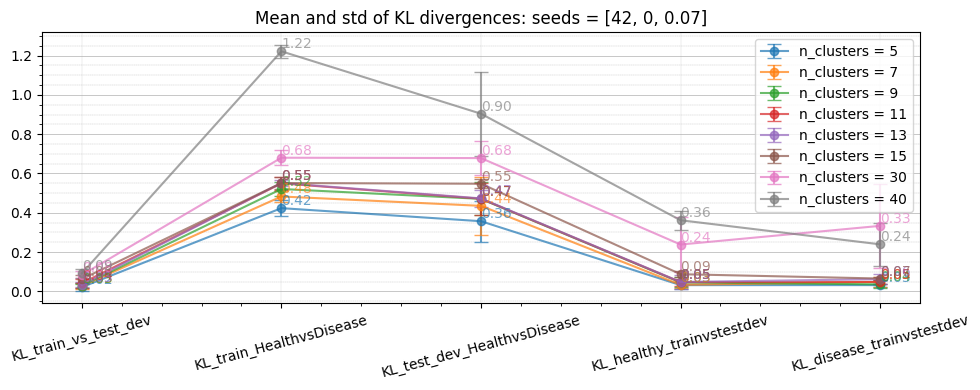

In [68]:
plt.figure(figsize=(10, 4))
xlabels = ['KL_train_vs_test_dev', 'KL_train_HealthvsDisease', 'KL_test_dev_HealthvsDisease', 'KL_healthy_trainvstestdev', 'KL_disease_trainvstestdev']
# find mean and std between the random seeds
mean_KL = np.mean(KL_storage_array, axis=2)
std_KL = np.std(KL_storage_array, axis=2)
for n_clusters_idx in range(len(n_clusters_wanted_list)):
    plt.errorbar(xlabels, mean_KL[:, n_clusters_idx], yerr=std_KL[:, n_clusters_idx], label=f'n_clusters = {n_clusters_wanted_list[n_clusters_idx]}', marker='o', capsize=5, alpha=0.7, color=f'C{n_clusters_idx}')
    # print the values on the plot
    for i in range(5):
        plt.text(i, mean_KL[i, n_clusters_idx], f'{mean_KL[i, n_clusters_idx]:.2f}', ha='left', va='bottom', color=f'C{n_clusters_idx}', alpha=0.67)
# rotate the xlabels
plt.xticks(rotation=15)
plt.legend()
plt.title(f'Mean and std of KL divergences: seeds = {random_seed_list}')
# add grid
# make minor ticks for y axis
plt.minorticks_on()
# remove minor ticks for x axis
plt.grid(True, which='Major', axis='x', linestyle='-', linewidth=0.15)
plt.grid(True, which='Major', axis='y', linestyle='-', linewidth=0.5)
plt.grid(True, which='Minor', axis='y', linestyle='--', linewidth=0.25)
plt.tight_layout()
# save the figure
seedlist_str = '-'.join([str(i) for i in random_seed_list])
plt.savefig(f'Mean_and_std_of_KL_divergences_seeds_{seedlist_str}.png')

In [65]:
KL_storage_array_backup = KL_storage_array.copy()

In [67]:
KL_storage_array

array([[[4.12554658e-02, 1.16085399e-03],
        [4.43958134e-02, 9.49435694e-03],
        [3.84110544e-02, 1.86521820e-02],
        [6.48510672e-02, 1.76193907e-02],
        [4.55654248e-02, 2.01229783e-02],
        [8.42138131e-02, 4.03589183e-02],
        [1.01243632e-01, 6.59215612e-02],
        [1.14144628e-01, 6.79748712e-02]],

       [[4.65692483e-01, 3.81371774e-01],
        [5.11062012e-01, 4.54797271e-01],
        [5.57154920e-01, 4.85047782e-01],
        [5.81751826e-01, 5.17666679e-01],
        [5.65621719e-01, 5.38006516e-01],
        [5.80952054e-01, 5.22002189e-01],
        [7.17255548e-01, 6.43263105e-01],
        [1.25592972e+00, 1.18824846e+00]],

       [[2.53620006e-01, 4.60437242e-01],
        [2.87990320e-01, 5.82508718e-01],
        [3.87424192e-01, 5.54148527e-01],
        [3.90514832e-01, 5.52463982e-01],
        [4.29477054e-01, 5.16836543e-01],
        [5.25765613e-01, 5.69891938e-01],
        [5.91607317e-01, 7.65268692e-01],
        [6.89898568e-01, 1.118

In [59]:
x = [1+2*i for i in range(1, 3+1)] # if I have one pixel in the middle and I use the surrounding ones
# take every 5th element
x_4th = x[::4]
x

[3, 5, 7]

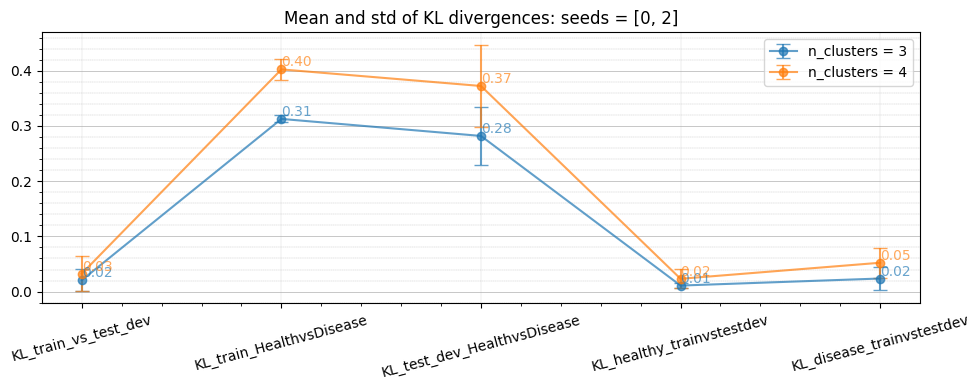

In [43]:
plt.figure(figsize=(10, 4))
xlabels = ['KL_train_vs_test_dev', 'KL_train_HealthvsDisease', 'KL_test_dev_HealthvsDisease', 'KL_healthy_trainvstestdev', 'KL_disease_trainvstestdev']
# find mean and std between the random seeds
mean_KL = np.mean(KL_storage_array, axis=2)
std_KL = np.std(KL_storage_array, axis=2)
for n_clusters_idx in range(len(n_clusters_wanted_list)):
    plt.errorbar(xlabels, mean_KL[:, n_clusters_idx], yerr=std_KL[:, n_clusters_idx], label=f'n_clusters = {n_clusters_wanted_list[n_clusters_idx]}', marker='o', capsize=5, alpha=0.7, color=f'C{n_clusters_idx}')
    # print the values on the plot
    for i in range(5):
        plt.text(i, mean_KL[i, n_clusters_idx], f'{mean_KL[i, n_clusters_idx]:.2f}', ha='left', va='bottom', color=f'C{n_clusters_idx}', alpha=0.67)
# rotate the xlabels
plt.xticks(rotation=15)
plt.legend()
plt.title(f'Mean and std of KL divergences: seeds = {random_seed_list}')
# add grid
# make minor ticks for y axis
plt.minorticks_on()
# remove minor ticks for x axis
plt.grid(True, which='Major', axis='x', linestyle='-', linewidth=0.15)
plt.grid(True, which='Major', axis='y', linestyle='-', linewidth=0.5)
plt.grid(True, which='Minor', axis='y', linestyle='--', linewidth=0.25)
plt.tight_layout()
# save the figure
seedlist_str = '-'.join([str(i) for i in random_seed_list])
plt.savefig(f'Mean_and_std_of_KL_divergences_seeds_{seedlist_str}.png')

In [ ]:
weights_startingpoint_norm = [i/max(weights_startingpoint) for i in weights_startingpoint]
weights_startingpoint_str = [f'{i:.2f}' for i in weights_startingpoint_norm]
weights_startingpoint_str = '-'.join(weights_startingpoint_str)
# changedot to underscore
weights_startingpoint_str = weights_startingpoint_str.replace('.', '_')
weights_startingpoint_str = f'weights_{weights_startingpoint_str}'
weights_startingpoint_str

In [ ]:

n_neighborhoods_wanted = 5
HSV_wanted = False
weights_startingpoint = [1, 1, 1.15] # Emphasize the IR channel by 15%
gamma_wanted = 0.7
random_seed = 42
n_clusters_wanted = 6
ScalingChoice_wanted = 1
extracted_path = f'{dir}\\Extracted_and_expanded'
files = os.listdir(extracted_path)
n_Classifiers = 8

def Mega_Run(extracted_path,
                     files,
                     n_Classifiers,
                     n_neighborhoods_wanted,
                     HSV_wanted,
                     weights_startingpoint,
                     gamma_wanted,
                     random_seed,
                     n_clusters_wanted,
                     ScalingChoice_wanted,
                     annotate = False):
    MegaDict = {} # initialize the dictionary
    timer_0 = time.time() # start the timer
    # Split into train, test, dev
    if annotate:
        print(f'Splitting into train, test, dev; Timepassed = {time.time()-timer_0:.2f}s')
    training_indices, test_indices, dev_indices = split_train_test(files_path = files, 
                                                                random_seed_wanted = random_seed, 
                                                                train_ratio = 0.8, 
                                                                test_to_dev_ratio = 0.5)

    # Add columns to the model (using 5 neighborhoods)
    cols_to_add, n_basecols = add_columns_to_model(n_neighborhoods = n_neighborhoods_wanted, 
                                                add_HSV = HSV_wanted)

    # Initialize the trainingarray

    if annotate:
        print(f'Extracting and adding columns to the training array; Timepassed = {time.time()-timer_0:.2f}s')
    training_nparray, training_nparray_labels = init_trainingArray(cols_to_add = cols_to_add, 
                                        training_idx = training_indices, 
                                        extracted_path = f'{dir}\\Extracted_and_expanded', 
                                        files = os.listdir(extracted_path), 
                                        n_Classifiers = n_Classifiers)

    # Add together the Test and dev indices
    
    if annotate:
        print(f'Extracting and adding columns to the test_dev array; Timepassed = {time.time()-timer_0:.2f}s')
    test_dev_indices = np.concatenate((test_indices, dev_indices))
    test_dev_nparray, test_dev_nparray_labels = init_trainingArray(cols_to_add = cols_to_add, 
                                        training_idx = test_dev_indices, 
                                        extracted_path = f'{dir}\\Extracted_and_expanded', 
                                        files = os.listdir(extracted_path),
                                        n_Classifiers = n_Classifiers)

    # Scale the trainingarray
    
    if annotate:
        print(f'Scaling the training array; Timepassed = {time.time()-timer_0:.2f}s')
    training_nparray_scaled, scaler_fitted = scaleArray(training_nparray = training_nparray, 
                                                                ScalingChoice = ScalingChoice_wanted)
    # Scale the test_dev array
    
    if annotate:
        print(f'Scaling the test_dev array; Timepassed = {time.time()-timer_0:.2f}s')
    test_dev_nparray_scaled = scaler_fitted.transform(test_dev_nparray)

    
    if annotate:
        print(f'Scaling the labels; Timepassed = {time.time()-timer_0:.2f}s')
    for i in range(n_Classifiers):
        training_nparray_labels[i] = scaler_fitted.transform(training_nparray_labels[i])
        test_dev_nparray_labels[i] = scaler_fitted.transform(test_dev_nparray_labels[i])

    # Generate weights for the trainingarray
    
    if annotate:
        print(f'Generating weights for the training array; Timepassed = {time.time()-timer_0:.2f}s')
    weights = create_weighing_array(n_basecols = n_basecols, 
                                    cols_to_add = cols_to_add, 
                                    weight_baseline = weights_startingpoint, 
                                    gamma = gamma_wanted) # Decay by 20% for each increase in neighborhood by 1

    # perform the weighting of the trainingarray
    if annotate:
        print(f'Weighting the training array; Timepassed = {time.time()-timer_0:.2f}s')
    training_nparray_scaled_weighted = weightArray(training_nparray = training_nparray_scaled,
                                                weights = weights)
    # perform the weighting of the test_dev array
    if annotate:
        print(f'Weighting the test_dev array; Timepassed = {time.time()-timer_0:.2f}s')
    test_dev_nparray_scaled_weighted = weightArray(training_nparray = test_dev_nparray_scaled,
                                                weights = weights)
    if annotate:
        print(f'Plotting the original and altered array; Timepassed = {time.time()-timer_0:.2f}s')
    for i in range(n_Classifiers):
        training_nparray_labels[i] = weightArray(training_nparray = training_nparray_labels[i],
                                                weights = weights)
        test_dev_nparray_labels[i] = weightArray(training_nparray = test_dev_nparray_labels[i],
                                                weights = weights)

    # Plot the original and altered array
    if annotate:
        print(f'Plotting the original and altered array; Timepassed = {time.time()-timer_0:.2f}s')
    plot_alteredarray(original_array = training_nparray_scaled, 
                    altered_array = training_nparray_scaled_weighted)


    # train the kmeans model on the training_nparray with the wanted metrics (n_clusters_wanted = 6) and random_state = 0 as defaults
    if annotate:
        print(f'Training the KMeans model: n_clusters = {n_clusters_wanted}, random_state = {random_seed}')
    KMeansclus = KMeans(n_clusters=n_clusters_wanted, random_state=random_seed).fit(training_nparray_scaled_weighted)
    # Predict the clusters for the test_dev array
    if annotate:
        print(f'Predicting the clusters for the training array')
    train_clusters = KMeansclus.predict(training_nparray_scaled_weighted)
    if annotate:
        print(f'Predicting the clusters for the test_dev array')
    test_dev_clusters = KMeansclus.predict(test_dev_nparray_scaled_weighted)

    for i in range(n_Classifiers):
        training_nparray_labels[f'{i}_clusters'] = KMeansclus.predict(training_nparray_labels[i])
        test_dev_nparray_labels[f'{i}_clusters'] = KMeansclus.predict(test_dev_nparray_labels[i])

    # Assess KL divergence between ALL pixels in the training, and ALL pixels in the test_dev
    KL_divergence_Train_vs_test_dev = KL_divergence(train_clusters, test_dev_clusters, n_clusters_wanted)

    # Assess the KL divergence for every label
    # First within the training
    KL_divergence_training_labels = np.zeros((n_Classifiers, n_Classifiers))
    # Then within the test_dev
    KL_divergence_test_dev_labels = np.zeros((n_Classifiers, n_Classifiers))
    # Then between the training and test_dev
    KL_divergence_training_test_dev_labels = np.zeros((n_Classifiers, n_Classifiers))
    for i in range(n_Classifiers):
        for j in range(n_Classifiers):
            KL_divergence_training_labels[i,j] = KL_divergence(training_nparray_labels[f'{i}_clusters'], training_nparray_labels[f'{j}_clusters'], n_clusters_wanted)
            KL_divergence_test_dev_labels[i,j] = KL_divergence(test_dev_nparray_labels[f'{i}_clusters'], test_dev_nparray_labels[f'{j}_clusters'], n_clusters_wanted)
            KL_divergence_training_test_dev_labels[i,j] = KL_divergence(training_nparray_labels[f'{i}_clusters'], test_dev_nparray_labels[f'{j}_clusters'], n_clusters_wanted)

    # store this data in a dictionary, keys are labelled with n_clusters_wanted, random_seed, n_neighborhoods_wanted, HSV_wanted, weights_startingpoint, gamma_wanted, ScalingChoice_wanted
    key_string = f'n_clusters = {n_clusters_wanted}, random_seed = {random_seed}, n_neighborhoods = {n_neighborhoods_wanted}, HSV = {HSV_wanted}, weights = {weights_startingpoint}, gamma = {gamma_wanted}, ScalingChoice = {ScalingChoice_wanted}'

    MegaDict[f'KL_divergence_Train_vs_test_dev_{key_string}'] = KL_divergence_Train_vs_test_dev
    MegaDict[f'KL_divergence_training_labels_{key_string}'] = KL_divergence_training_labels
    MegaDict[f'KL_divergence_test_dev_labels_{key_string}'] = KL_divergence_test_dev_labels
    MegaDict[f'KL_divergence_training_test_dev_labels_{key_string}'] = KL_divergence_training_test_dev_labels

        
    Healthy_training_l, Healthy_test_dev_l, Disease_training_l, Disease_test_dev_l = get_Healthy_vs_Disease_npArrays(training_nparray_labels = training_nparray_labels, 
                                                                                                                    test_dev_nparray_labels = test_dev_nparray_labels, 
                                                                                                                    n_Classifiers = n_Classifiers, 
                                                                                                                    Healthy_labels = [5, 6], 
                                                                                                                    Disease_labels = [0, 3, 4])

    KL_divergence_train_HealthvsDisease = KL_divergence(Healthy_training_l, Disease_training_l, n_clusters_wanted)
    KL_divergence_test_dev_HealthvsDisease = KL_divergence(Healthy_test_dev_l, Disease_test_dev_l, n_clusters_wanted)
    KL_divergence_healthy_trainvstestdev = KL_divergence(Healthy_training_l, Healthy_test_dev_l, n_clusters_wanted)
    KL_divergence_disease_trainvstestdev = KL_divergence(Disease_training_l, Disease_test_dev_l, n_clusters_wanted)

    MegaDict[f'KL_divergence_train_HealthvsDisease_{key_string}'] = KL_divergence_train_HealthvsDisease
    MegaDict[f'KL_divergence_test_dev_HealthvsDisease_{key_string}'] = KL_divergence_test_dev_HealthvsDisease
    MegaDict[f'KL_divergence_healthy_trainvstestdev_{key_string}'] = KL_divergence_healthy_trainvstestdev
    MegaDict[f'KL_divergence_disease_trainvstestdev_{key_string}'] = KL_divergence_disease_trainvstestdev

    KL_singles = [KL_divergence_Train_vs_test_dev,\
                KL_divergence_train_HealthvsDisease,\
                    KL_divergence_test_dev_HealthvsDisease,\
                        KL_divergence_healthy_trainvstestdev,\
                            KL_divergence_disease_trainvstestdev]

    # save the dict as a pickle with the name f'Megadict_nClus_{n_clusters_wanted}_seed_{random_seed}_nhoods_{n_neighborhoods_wanted}.pkl'
    savename = f'Megadict_nClus_{n_clusters_wanted}_seed_{random_seed}_nhoods_{n_neighborhoods_wanted}.pkl'
    with open(savename, 'wb') as f:
        pickle.dump(MegaDict, f)


    # Create a figure for the KL divergences
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    sns.heatmap(KL_divergence_training_labels, ax=ax[0, 0], cmap='viridis')
    ax[0, 0].set_title('Training: Internal Label Differences')
    sns.heatmap(KL_divergence_test_dev_labels, ax=ax[0, 1], cmap='viridis')
    ax[0, 1].set_title('Test_dev: Internal Label Differences')
    sns.heatmap(KL_divergence_training_test_dev_labels, ax=ax[1, 0], cmap='viridis')
    ax[1, 0].set_title('Training vs Test_dev: Label Differences')
    ax[1, 1].plot(range(5), KL_singles, marker='o')
    # set the xticks to be the names of the KL_singles
    ax[1, 1].set_xticks(range(5))
    ax[1, 1].set_xticklabels(['Train vs Test_dev', 'Train_Health vs Disease', 'Test_dev_Health vs Disease', 'Healthy Train vs Test_dev', 'Disease Train vs Test_dev'])
    ax[1, 1].tick_params(axis='x', rotation=45)
    ax[1, 1].set_title('Single KL divergences')
    plt.suptitle(f'{savename[:-4]}')
    plt.tight_layout()

    # Save the image
    fig.savefig(f'{savename[:-4]}.png')

    if annotate:
        print(f'Finished; Timepassed = {time.time()-timer_0:.2f}s')
    
    return MegaDict


In [ ]:
# Create a figure for the KL divergences
cmap = 'bone'
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.heatmap(KL_divergence_training_labels, ax=ax[0, 0], cmap=cmap, annot=True, fmt='.2f')
ax[0, 0].set_title('Training: Internal Label Differences')
sns.heatmap(KL_divergence_test_dev_labels, ax=ax[0, 1], cmap=cmap, annot=True, fmt='.2f')
ax[0, 1].set_title('Test_dev: Internal Label Differences')
sns.heatmap(KL_divergence_training_test_dev_labels, ax=ax[1, 0], cmap=cmap, annot=True, fmt='.2f')
ax[1, 0].set_title('Training vs Test_dev: Label Differences')
ax[1, 1].plot(range(5), KL_singles, marker='o')
# set the xticks to be the names of the KL_singles
ax[1, 1].set_xticks(range(5))
ax[1, 1].set_xticklabels(['Train vs Test_dev', 'Train_Health vs Disease', 'Test_dev_Health vs Disease', 'Healthy Train vs Test_dev', 'Disease Train vs Test_dev'])
# rotate the xlabels
ax[1, 1].tick_params(axis='x', rotation=45)
ax[1, 1].set_title('Single KL divergences')
plt.suptitle(f'{savename[:-4]}')
plt.tight_layout()

# Save the image
fig.savefig(f'{savename[:-4]}.png')


In [ ]:
Healthy_training_l, Healthy_test_dev_l, Disease_training_l, Disease_test_dev_l = get_Healthy_vs_Disease_npArrays(training_nparray_labels = training_nparray_labels, 
                                                                                                                 test_dev_nparray_labels = test_dev_nparray_labels, 
                                                                                                                 n_Classifiers = n_Classifiers, 
                                                                                                                 Healthy_labels = [5, 6], 
                                                                                                                 Disease_labels = [0, 3, 4])

# Assess KL divergence between ALL pixels in the training, and ALL pixels in the test_dev
KL_divergence_Train_vs_test_dev = KL_divergence(train_clusters, test_dev_clusters, n_clusters_wanted)
MegaDict = {}
# Assess the KL divergence for every label
# First within the training
KL_divergence_training_labels = np.zeros((n_Classifiers, n_Classifiers))
# Then within the test_dev
KL_divergence_test_dev_labels = np.zeros((n_Classifiers, n_Classifiers))
# Then between the training and test_dev
KL_divergence_training_test_dev_labels = np.zeros((n_Classifiers, n_Classifiers))
for i in range(n_Classifiers):
    for j in range(n_Classifiers):
        KL_divergence_training_labels[i,j] = KL_divergence(training_nparray_labels[f'{i}_clusters'], training_nparray_labels[f'{j}_clusters'], n_clusters_wanted)
        KL_divergence_test_dev_labels[i,j] = KL_divergence(test_dev_nparray_labels[f'{i}_clusters'], test_dev_nparray_labels[f'{j}_clusters'], n_clusters_wanted)
        KL_divergence_training_test_dev_labels[i,j] = KL_divergence(training_nparray_labels[f'{i}_clusters'], test_dev_nparray_labels[f'{j}_clusters'], n_clusters_wanted)

KL_divergence_train_HealthvsDisease = KL_divergence(Healthy_training_l, Disease_training_l, n_clusters_wanted)
KL_divergence_test_dev_HealthvsDisease = KL_divergence(Healthy_test_dev_l, Disease_test_dev_l, n_clusters_wanted)
KL_divergence_healthy_trainvstestdev = KL_divergence(Healthy_training_l, Healthy_test_dev_l, n_clusters_wanted)
KL_divergence_disease_trainvstestdev = KL_divergence(Disease_training_l, Disease_test_dev_l, n_clusters_wanted)

# store this data in a dictionary, keys are labelled with n_clusters_wanted, random_seed, n_neighborhoods_wanted, HSV_wanted, weights_startingpoint, gamma_wanted, ScalingChoice_wanted
key_string = f'n_clusters = {n_clusters_wanted}, random_seed = {random_seed}, n_neighborhoods = {n_neighborhoods_wanted}, HSV = {HSV_wanted}, weights = {weights_startingpoint}, gamma = {gamma_wanted}, ScalingChoice = {ScalingChoice_wanted}'

MegaDict[f'KL_divergence_Train_vs_test_dev_{key_string}'] = KL_divergence_Train_vs_test_dev
MegaDict[f'KL_divergence_training_labels_{key_string}'] = KL_divergence_training_labels
MegaDict[f'KL_divergence_test_dev_labels_{key_string}'] = KL_divergence_test_dev_labels
MegaDict[f'KL_divergence_training_test_dev_labels_{key_string}'] = KL_divergence_training_test_dev_labels
MegaDict[f'KL_divergence_train_HealthvsDisease_{key_string}'] = KL_divergence_train_HealthvsDisease
MegaDict[f'KL_divergence_test_dev_HealthvsDisease_{key_string}'] = KL_divergence_test_dev_HealthvsDisease
MegaDict[f'KL_divergence_healthy_trainvstestdev_{key_string}'] = KL_divergence_healthy_trainvstestdev
MegaDict[f'KL_divergence_disease_trainvstestdev_{key_string}'] = KL_divergence_disease_trainvstestdev

# save the dict as a pickle with the name f'Megadict_nClus_{n_clusters_wanted}_seed_{random_seed}_nhoods_{n_neighborhoods_wanted}.pkl'
savename = f'Megadict_nClus_{n_clusters_wanted}_seed_{random_seed}_nhoods_{n_neighborhoods_wanted}.pkl'
with open(savename, 'wb') as f:
    pickle.dump(MegaDict, f)

maxKL_ofall = np.max([KL_divergence_Train_vs_test_dev, KL_divergence_train_HealthvsDisease, KL_divergence_test_dev_HealthvsDisease, KL_divergence_healthy_trainvstestdev, KL_divergence_disease_trainvstestdev])

# Create a figure for the KL divergences
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.heatmap(KL_divergence_training_labels, ax=ax[0, 0], cmap='viridis')
ax[0,0].set_title('Training: Internal Label Differences')
ax[0, 1].imshow(KL_divergence_test_dev_labels, cmap='viridis')
ax[1, 0].imshow(KL_divergence_training_test_dev_labels, cmap='viridis')
plt.suptitle(f'{savename[:-4]}')

plt.tight_layout()

In [ ]:
maxKL_ofall = np.max([KL_divergence_Train_vs_test_dev, KL_divergence_train_HealthvsDisease, KL_divergence_test_dev_HealthvsDisease, KL_divergence_healthy_trainvstestdev, KL_divergence_disease_trainvstestdev])
maxKL_ofall

In [ ]:

# Use the KMeans algorithm to cluster the data for both the training and test_dev arrays

# train the kmeans model on the training_nparray with the wanted metrics (n_clusters_wanted = 6) and random_state = 0 as defaults
print(f'Training the KMeans model: n_clusters = {n_clusters_wanted}, random_state = {random_seed}')
KMeansclus = KMeans(n_clusters=n_clusters_wanted, random_state=random_seed).fit(training_nparray_scaled_weighted)
# Predict the clusters for the test_dev array
print(f'Predicting the clusters for the training array')
train_clusters = KMeansclus.predict(training_nparray_scaled_weighted)
print(f'Predicting the clusters for the test_dev array')
test_dev_clusters = KMeansclus.predict(test_dev_nparray_scaled_weighted)

for i in range(n_Classifiers):
    training_nparray_labels[f'{i}_clusters'] = KMeansclus.predict(training_nparray_labels[i])
    test_dev_nparray_labels[f'{i}_clusters'] = KMeansclus.predict(test_dev_nparray_labels[i])
    


In [ ]:
def get_Healthy_vs_Disease_npArrays(training_nparray_labels, test_dev_nparray_labels, Healthy_labels = [5, 6], Disease_labels = [0, 3, 4]):
    # Assuming definitions of your variables and n_Classifiers somewhere above this code
    Healthy_labels = [5, 6]
    Healthy_training_nparray_labels = np.array([])
    Healthy_test_dev_nparray_labels = np.array([])
    Disease_labels = [0, 3, 4]
    Disease_training_nparray_labels = np.array([])
    Disease_test_dev_nparray_labels = np.array([])

    for i in range(n_Classifiers):
        if i in Healthy_labels:
            # Use .size to check if the array is empty
            if Healthy_training_nparray_labels.size == 0:
                Healthy_training_nparray_labels = training_nparray_labels[f'{i}_clusters']
                Healthy_test_dev_nparray_labels = test_dev_nparray_labels[f'{i}_clusters']
            else:
                Healthy_training_nparray_labels = np.hstack((Healthy_training_nparray_labels, training_nparray_labels[f'{i}_clusters']))
                Healthy_test_dev_nparray_labels = np.hstack((Healthy_test_dev_nparray_labels, test_dev_nparray_labels[f'{i}_clusters']))
        elif i in Disease_labels:
            if Disease_training_nparray_labels.size == 0:
                Disease_training_nparray_labels = training_nparray_labels[f'{i}_clusters']
                Disease_test_dev_nparray_labels = test_dev_nparray_labels[f'{i}_clusters']
            else:
                Disease_training_nparray_labels = np.hstack((Disease_training_nparray_labels, training_nparray_labels[f'{i}_clusters']))
                Disease_test_dev_nparray_labels = np.hstack((Disease_test_dev_nparray_labels, test_dev_nparray_labels[f'{i}_clusters']))
    return Healthy_training_nparray_labels, Healthy_test_dev_nparray_labels, Disease_training_nparray_labels, Disease_test_dev_nparray_labels

In [ ]:
# Assess the divergence between the Healthy and Disease clusters for the training

def KL_divergence(A, B, n_clusters_wanted, smoothing_value = 1e-10):
    # A and B are two arrays
    A_probs = np.zeros(n_clusters_wanted)
    B_probs = np.zeros(n_clusters_wanted)
    for i in range(n_clusters_wanted):
        A_probs[i] = np.sum(A == i)/len(A)
        B_probs[i] = np.sum(B == i)/len(B)
        
    # Adding a small constant to avoid division by zero or log(0)
    A_probs += smoothing_value
    B_probs += smoothing_value
    
    # Ensure normalization after adding smoothing_value
    A_probs /= A_probs.sum()
    B_probs /= B_probs.sum()
        
    KL_divergence = np.sum(A_probs * np.log(A_probs/B_probs))
    return KL_divergence

KL_divergence_train = KL_divergence(Healthy_training_nparray_labels, Disease_training_nparray_labels, n_clusters_wanted)
KL_divergence_test_dev = KL_divergence(Healthy_test_dev_nparray_labels, Disease_test_dev_nparray_labels, n_clusters_wanted)
KL_divergence_healthy = KL_divergence(Healthy_training_nparray_labels, Healthy_test_dev_nparray_labels, n_clusters_wanted)
KL_divergence_disease = KL_divergence(Disease_training_nparray_labels, Disease_test_dev_nparray_labels, n_clusters_wanted)

print(f'KL divergence between Healthy and Disease clusters for the training: {KL_divergence_train}')
print(f'KL divergence between Healthy and Disease clusters for the test_dev: {KL_divergence_test_dev}')
print(f'KL divergence between Healthy clusters for the training and test_dev: {KL_divergence_healthy}')
print(f'KL divergence between Disease clusters for the training and test_dev: {KL_divergence_disease}')

# Interpreting the KL divergence
# If the KL divergence is high between the training and test_dev, then the model is overfitting
# If the KL divergence is high between the healthy and disease clusters, then the model can distinguish between the two

In [ ]:
Healthy_training_nparray_labels

In [ ]:
Healthy_training_nparray_labels = np.array([x for x in Healthy_training_nparray_labels if x.size != 0])


In [ ]:
weights = create_weighing_array(n_basecols, cols_to_add, weight_baseline = [1, 1, 1], gamma = 0.8)
weights

In [ ]:
weight_baseline

In [ ]:
def create_weighing_array(training_nparray, weight_baseline, scaling_performed_Flag, gamma = 1.2,  figure_wanted = False):

    
    if not scaling_performed_Flag:
        ValueError('Scaling must be performed before weighting')
        return None
    
    originaldata_np = training_nparray.copy()
    
    # scale features based on columns
    for i in range(training_nparray.shape[1]):
        training_nparray[:,i] = training_nparray[:,i] * weights[i]
    
    if figure_wanted:
        # Example to show how we smear the data we are less interested in (far neighbors are less important)
        # create two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        sns.heatmap(originaldata_np[1:5000,:], ax=ax1)
        print(np.max(originaldata_np[0:500,:], axis=0))
        # Example to show how we smear the data we are less interested in (far neighbors are less important)
        sns.heatmap(training_nparray[1:5000,:], ax=ax2)
        print(np.max(training_nparray[0:500,:], axis=0))
        
    return weights, weightingperformed_Flag

# Perform Weighting
weightingperformed = True

# The weights are in the same order as the columns in cols_to_add so change the weights accordingly 
weights = [1,1,1,\
        1/1.2, 1/1.2, 1/1.2,\
        1/1.6, 1/1.6, 1/1.6,\
        1/2, 1/2, 1/2,\
        1/3, 1/3, 1/3,\
        1/4, 1/4, 1/4,\
        1/5, 1/5, 1/5,\
        1/6, 1/6, 1/6,\
        1/7, 1/7, 1/7,\
        1/8, 1/8, 1/8,\
        1/9, 1/9, 1/9,\
        1/10, 1/10, 1/10]
originaldata_np = training_nparray.copy()
if weightingperformed and scalingperformed:
    print(f'Weights: {weightingperformed}')
    # scale features based on columns
    for i in range(training_nparray.shape[1]):
        training_nparray[:,i] = training_nparray[:,i] * weights[i]
if not scalingperformed:
    print('Will not scale weights because scaling was not performed')
    

# Example to show how we smear the data we are less interested in (far neighbors are less important)
# create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(originaldata_np[1:5000,:], ax=ax1)
print(np.max(originaldata_np[0:500,:], axis=0))
# Example to show how we smear the data we are less interested in (far neighbors are less important)
sns.heatmap(training_nparray[1:5000,:], ax=ax2)
print(np.max(training_nparray[0:500,:], axis=0))

In [ ]:
# train the kmeans model on the training_nparray with the wanted metrics (n_clusters_wanted = 6) and random_state = 0 as defaults
n_clusters_wanted = 60 #40

KMeansclus = KMeans(n_clusters=n_clusters_wanted, random_state=0).fit(training_nparray)
# The time it takes for training the model on the training data depends on the training data size and the number of clusters we want.
# For an idea with Kmeans clusters n = 6 and 80% training ratio and only 3 columns chosen it takes 3 and a half minutes on Hallur's laptop.

In [ ]:
# If you want to run prediction on the training_nparray with all settings
# Note that you should not have any of the csv files from the Extracted_and_expanded folder open when you run this as it will not be able to overwrite the csv files.
# A new column will then be created for all images in the Extracted_and_expanded folder with the prediction based on the training_nparray and the n_clusters_wanted.
# example new column name = 'Predicted w ['RGB: FAF', 'RGB: GREEN', 'RGB: IR'], n_clusters 7_StandardScaler_weighted'

showimage = False
print(f'Predicted w/ {cols_to_add}, n_clusters {n_clusters_wanted}')

# Put these predictions into the dataframe
for show_file_idx in range(len(files)):
    
    print(f'Working on {files[show_file_idx]}, {show_file_idx+1}/{len(files)}')
    
    # check what the fitted model looks like on one image
    temp_img = pd.read_csv(extracted_path + '\\' + files[show_file_idx])

    # use the columns to get the RGB values
    if scalingperformed:
        temp_np = scaler.transform(temp_img[cols_to_add].to_numpy())
        
        # scale features based on columns
        if weightingperformed:
            for i in range(temp_np.shape[1]):
                temp_np[:,i] = temp_np[:,i] * weights[i]
        
        predicted = KMeansclus.predict(temp_np)
    else:
        predicted = KMeansclus.predict(temp_img[cols_to_add].to_numpy())

    # add the predicted column to the dataframe
    if scalingperformed:
        if weightingperformed:
            temp_img[f'Predicted w {cols_to_add}, n_clusters {n_clusters_wanted}_{scalingmethod_performed}_weighted'] = predicted
        else:
            temp_img[f'Predicted w {cols_to_add}, n_clusters {n_clusters_wanted}_{scalingmethod_performed}'] = predicted
    else:
        temp_img[f'Predicted w {cols_to_add}, n_clusters {n_clusters_wanted}'] = predicted

    
    # overwrite save as csv
    temp_img.to_csv(extracted_path + '\\' + files[show_file_idx], index=False)

    if showimage:
        clear_output(wait=True)
        for i in range(n_clusters_wanted):
            print(f'Cluster {i} has {temp_img[temp_img[f"Predicted w {cols_to_add}, n_clusters {n_clusters_wanted}"] == i].shape[0]} points')
        # temp_img[temp_img['Classifier'] == 1][f'Predicted w {cols_to_add}, n_clusters {n_clusters_wanted}'].value_counts()
        # get the rows where Classifier is not nan
        Classified = temp_img[temp_img['Classifier'].notna()]
        unique_classified = Classified['Classifier'].unique()
        unique_classified = np.sort(unique_classified)
        for i in unique_classified:
            # get the value counts of the f"Predicted w {cols_to_add}, n_clusters {n_clusters_wanted}" column for each unique classifier
            print(f'Likelyhood of cluster {int(i)} being in each cluster: \n{Classified[Classified["Classifier"] == i][f"Predicted w {cols_to_add}, n_clusters {n_clusters_wanted}"].value_counts(normalize=True)}')
        
        # Extract the shape of the image from the unique values in X and Y
        height = np.max(temp_img['Y'].nunique())
        width = np.max(temp_img['X'].nunique())

        # Create an empty array for the image
        image_array = np.zeros((height, width, 1), dtype=np.uint8)

        # Fill the array with values from the dataframe
        for _, row in temp_img.iterrows():
            y, x = int(row['Y']), int(row['X'])
            image_array[y, x] = predicted[_]

        # Display the image
        plt.imshow(image_array, cmap='Spectral')
        plt.axis('off')
        plt.suptitle(f'{files[show_file_idx]}')
        plt.title(f'Prediction based on {cols_to_add}, n_clusters = {n_clusters_wanted}')
        plt.colorbar()
        plt.show()

In [ ]:
filelist = files.copy()
trainfiles = [filelist[training_index] for training_index in training_indices]
testsfiles_all = [n for n in filelist if n not in trainfiles]
example_df = pd.read_csv(extracted_path + '\\' + trainfiles[0])

# Loop through all the csv files in I:\Natalie\Images and grader results\Grader results
temp_dir = r'I:\Natalie\Images and grader results\Grader results'
Counter = []
for file in os.listdir(temp_dir):
    if file.endswith('.csv'):
        temp_df = pd.read_csv(temp_dir + '\\' + file)
        vals = [int(i) for i in temp_df['Counter'].values]
        Counter = Counter + vals
# get all "Classifier" unique values
classifiers_unique = np.unique(np.asarray(Counter))
classifiers_unique
# Counter

In [ ]:
# Check the image gained by the clustering of colum created

if scalingperformed:
    if weightingperformed:
        clustercol = f'Predicted w {cols_to_add}, n_clusters {n_clusters_wanted}_{scalingmethod_performed}_weighted'
    else:
        clustercol = f'Predicted w {cols_to_add}, n_clusters {n_clusters_wanted}_{scalingmethod_performed}'
else:
    clustercol = f'Predicted w {cols_to_add}, n_clusters {n_clusters_wanted}'

# find the index choice that has choice_now in files
choice_now = '25691 OS.csv'

idx_choice = [i for i in range(len(files)) if choice_now in files[i]][0]
df = pd.read_csv(extracted_path + '\\' + files[idx_choice])
print(f'File {files[idx_choice]}')

S1_img_path = r'I:\Natalie\Images and grader results\S1 images (53 eyes)'
# S1_img_path = r'D:\Natalie\Images and grader results\S1 images (53 eyes)'
current_folder = S1_img_path + '\\' + files[idx_choice][:-7]
current_images = os.listdir(current_folder)
eye = files[idx_choice][-6:-4]
current_images = [i for i in current_images if 'preprocessed' in i]# throw out files that do not contain 'preprocessed'	
current_images = [i for i in current_images if eye in i]
print(f'Working on {files[idx_choice]}')
print(f'Eye: {eye}')
FAFimg = [i for i in current_images if 'FAF' in i][0]
greenimg = [i for i in current_images if 'green' in i][0]
IRimg = [i for i in current_images if 'IR' in i][0]
# make composite image where FAF is red, green is green, and IR is blue
FAF = cv2.imread(current_folder + '\\' + FAFimg)
GREEN = cv2.imread(current_folder + '\\' + greenimg)
IR = cv2.imread(current_folder + '\\' + IRimg)


# Extract the shape of the image from the unique values in X and Y
height = df['Y'].nunique()
width = df['X'].nunique()

# Create an empty array for the image
image_array1 = np.zeros((height, width, 1), dtype=np.uint8)
image_array2 = np.zeros((height, width, 3), dtype=np.uint8)
image_array3 = np.zeros((height, width, 3), dtype=np.uint8)

# Fill the array with values from the dataframe
for _, row in df.iterrows():
    y, x = int(row['Y']), int(row['X'])
    image_array1[y, x] = [row[clustercol]]
    image_array2[y, x] = [row['RGB: FAF'], row['RGB: GREEN'], row['RGB: IR']]
    image_array3[y, x] = [row['HSV: Hue'], row['HSV: Saturation'], row['HSV: Brightness']]

# Modify pixels where Classifier is not NaN to be pure red
condition = ~df['Classifier'].isna()
for _, row in df[condition].iterrows():
    y, x = int(row['Y']), int(row['X'])
    for i in range(-3, 4):
        image_array2[y+i, x] = [255, 0, 0]
        image_array3[y+i, x] = [255, 0, 0]
    for j in range(-3,4):
        image_array2[y, x+j] = [255, 0, 0]
        image_array3[y, x+j] = [255, 0, 0]

# colchecks = ["Predicted w ['RGB: FAF', 'RGB: GREEN', 'RGB: IR', 'HSV: Hue', 'HSV: Saturation', 'HSV: Brightness'], n_clusters 10_StandardScaler",\
#     "Predicted w ['RGB: FAF', 'RGB: GREEN', 'RGB: IR'], n_clusters 10_StandardScaler",\
#     "Predicted w ['HSV: Hue', 'HSV: Saturation', 'HSV: Brightness'], n_clusters 10_StandardScaler",\
#     "Predicted w ['RGB: FAF', 'RGB: GREEN', 'RGB: IR', 'HSV: Hue', 'HSV: Saturation', 'HSV: Brightness', 'RGB: FAF, n_hood=1', 'RGB: GREEN, n_hood=1', 'RGB: IR, n_hood=1', 'RGB: FAF, n_hood=2', 'RGB: GREEN, n_hood=2', 'RGB: IR, n_hood=2', 'RGB: FAF, n_hood=3', 'RGB: GREEN, n_hood=3', 'RGB: IR, n_hood=3', 'RGB: FAF, n_hood=4', 'RGB: GREEN, n_hood=4', 'RGB: IR, n_hood=4', 'RGB: FAF, n_hood=5', 'RGB: GREEN, n_hood=5', 'RGB: IR, n_hood=5'], n_clusters 10_StandardScaler_weighted",\
#     ]

Classifiers = np.sort(df['Classifier'].unique())
current_Classifier = Classifiers[0]
# current_colcheck = colchecks[0]
colchecks = [clustercol]
# see the normal values for each classifier
for current_Classifier_idx in range(len(Classifiers)):
    current_Classifier = Classifiers[current_Classifier_idx]
    print(f'Classifier: {current_Classifier}')
    for current_colcheck_idx in range(len(colchecks)):
        current_colcheck = colchecks[current_colcheck_idx]
        print(f'Colcheck: {current_colcheck}')
        print(df[df['Classifier'] == current_Classifier][current_colcheck].value_counts(normalize=True))
    print('\n')

In [ ]:
temp_df = pd.read_csv(extracted_path + '\\' + file)
temp_df['Classifier'].unique()
for i in temp_df['Classifier'].unique():
    print(i==i)

In [ ]:
file = trainfiles[0]
temp_df = pd.read_csv(extracted_path + '\\' + file)
temp_df = temp_df[[clustercol, 'Classifier']]
# temp_df['Classifier'].unique()
i = temp_df['Classifier'].unique()[0]
training_Holder = dict()
training_Holder['nan'] = []
# training_Holder[int(i)] = []
X = temp_df[temp_df['Classifier'].isna()][clustercol].value_counts(normalize=False)
X
print(X)

In [ ]:
temp_df = pd.read_csv(extracted_path + '\\' + file)
temp_df = temp_df[[clustercol, 'Classifier']]
temp_df

In [ ]:
def evaluation_Train_vs_Test(
                             clustercol_title, 
                             filelist
                             ):
    # Create placeholder for the training and testing data
    Holder = dict()
    for file in filelist:
        temp_df = pd.read_csv(extracted_path + '\\' + file)
        # only keep the clustercol and the "Classifier" columns
        temp_df = temp_df[[clustercol_title, 'Classifier']]
        for i in temp_df['Classifier'].unique():
            
            if not i == i:
                # check if the key is in the dictionary
                if 'nan' not in Holder:
                    Holder['nan'] = {}
                # save the length of the dataframe where Classifier is NaN
                X = temp_df[temp_df['Classifier'].isna()][clustercol].value_counts(normalize=False)
                X = X.to_dict()
                for key in X:
                    if key not in Holder['nan']:
                        Holder['nan'][key] = 0
                    Holder['nan'][key] += X[key]
                
            else:
                # check if the key is in the dictionary
                if int(i) not in Holder:
                    Holder[int(i)] = {}
                
                X = temp_df[temp_df['Classifier']==i][clustercol].value_counts(normalize=False)
                X = X.to_dict()
                for key in X:
                    if key not in Holder[int(i)]:
                        Holder[int(i)][key] = 0
                    Holder[int(i)][key] += X[key]
        
    return Holder

filelist_all = files.copy()
trainfiles = [filelist[training_index] for training_index in training_indices]
testsfiles_all = [n for n in filelist if n not in trainfiles]
example_df = pd.read_csv(extracted_path + '\\' + trainfiles[0])

# Loop through all the csv files in I:\Natalie\Images and grader results\Grader results
temp_dir = r'I:\Natalie\Images and grader results\Grader results'
Counter = []
for file in os.listdir(temp_dir):
    if file.endswith('.csv'):
        temp_df = pd.read_csv(temp_dir + '\\' + file)
        vals = [int(i) for i in temp_df['Counter'].values]
        Counter = Counter + vals
# get all "Classifier" unique values
classifiers_unique = np.unique(np.asarray(Counter))
classifiers_unique

training_Holder = evaluation_Train_vs_Test(
                                            clustercol_title = clustercol, 
                                            filelist = trainfiles
                                            )

testing_Holder = evaluation_Train_vs_Test(
                                            clustercol_title = clustercol, 
                                            filelist = testsfiles_all
                                            )

In [ ]:
allkeys = list(training_Holder.keys()) + list(testing_Holder.keys())
allkeys = np.unique(np.sort(np.asarray([key for key in allkeys if key != 'nan'])))
allkeys

def getmatrix_fromdict(
                        Holder, 
                        allkeys, 
                        n_clusters_wanted
                        ):
    # create two matrixes for the training and testing data
    matrix = np.zeros((len(allkeys)+1, n_clusters_wanted))
    training_matrix = np.zeros((len(allkeys)+1, n_clusters_wanted))
    for i in range(-1, len(allkeys)):
        if i == -1:
            for key in Holder['nan']:
                matrix[i, key] = Holder['nan'][key]
        if allkeys[i] in Holder:
            for key in Holder[allkeys[i]]:
                matrix[i, key] = Holder[allkeys[i]][key]
    return matrix

# create two matrixes for the training and testing data
training_matrix = getmatrix_fromdict(Holder = training_Holder, 
                                     allkeys = allkeys, 
                                     n_clusters_wanted = n_clusters_wanted)
testing_matrix = getmatrix_fromdict(Holder = testing_Holder,
                                    allkeys = allkeys, 
                                    n_clusters_wanted = n_clusters_wanted)


In [ ]:
# make 2x2 subplots
import seaborn as sns
xolormap = 'icefire'
vmin_val = -1.5
vmax_val = 1.5
fig, axs = plt.subplots(4, 3, figsize=(20, 8))
plt.suptitle(f'Comparison of training and testing data')
sns.heatmap(training_matrix[:-1,:], ax=axs[0, 0], cmap=xolormap)
sns.heatmap(testing_matrix[:-1,:], ax=axs[0, 1], cmap=xolormap)
sns.heatmap(training_matrix[-1:,:], ax=axs[1, 0], cmap=xolormap)
sns.heatmap(testing_matrix[-1:,:], ax=axs[1, 1], cmap=xolormap)
# normalize all rows
training_matrix_norm = training_matrix / training_matrix.max(axis=1)[:,None]
testing_matrix_norm = testing_matrix / testing_matrix.max(axis=1)[:,None]
sns.heatmap(training_matrix_norm[:-1,:], ax=axs[2, 0], cmap=xolormap, vmin=vmin_val, vmax=vmax_val)
sns.heatmap(testing_matrix_norm[:-1,:], ax=axs[2, 1], cmap=xolormap, vmin=vmin_val, vmax=vmax_val)

# now compare the training and testing data to the right
train_plus_test = training_matrix_norm + testing_matrix_norm
sns.heatmap(train_plus_test[-1:,:], ax=axs[1, 2], cmap=xolormap, vmin=vmin_val, vmax=vmax_val)
sns.heatmap(train_plus_test[:-1,:], ax=axs[2, 2], cmap=xolormap, vmin=vmin_val, vmax=vmax_val)

# subtract the last row from all other rows
for row in range(training_matrix_norm.shape[0]-1):
    training_matrix_norm[row,:] = training_matrix_norm[row,:] - training_matrix_norm[-1,:]
    testing_matrix_norm[row,:] = testing_matrix_norm[row,:] - testing_matrix_norm[-1,:]
sns.heatmap(training_matrix_norm[:-1,:], ax=axs[3, 0], cmap=xolormap, vmin=vmin_val, vmax=vmax_val)
sns.heatmap(testing_matrix_norm[:-1,:], ax=axs[3, 1], cmap=xolormap, vmin=vmin_val, vmax=vmax_val)


# now compare the training and testing data to the right
train_plus_test = training_matrix_norm + testing_matrix_norm
sns.heatmap(train_plus_test[:-1,:], ax=axs[3, 2], cmap=xolormap, vmin=vmin_val, vmax=vmax_val)
plt.tight_layout()

# Disease 0, 3!, 4!, (1, 2 mehh), (7 not worth our preciousness) [people suck at diff 0 from 3]
# Healthy 5, 6

# KL Div
# Hypo : if u use img that is specific to the disease, u will get a better result; Comp approach 

In [ ]:
# take rows 5 and 6
BackgroundandVessels_train = np.sum(training_matrix[[5,6],:], axis=0)
BackgroundandVessels_test = np.sum(testing_matrix[[5,6],:], axis=0)

# take rows 0, 3, 4
Disease_train = np.sum(training_matrix[[0,3,4],:], axis=0)
Disease_test = np.sum(testing_matrix[[0,3,4],:], axis=0)

In [ ]:
Disease_train

In [ ]:
# To assess KL - Divergence first we need to normalize the data such that the sum of each row is 1
# Normalize the data
def normalize_data(vector):
    return vector / vector.sum()

def KL_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def mutual_info(p, q):
    return KL_divergence(p, q) + KL_divergence(q, p)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 8))
axs[0, 0].plot(BackgroundandVessels_train, label='Background and Vessels', color='blue')
axs[0, 0].plot(BackgroundandVessels_test, label='Background and Vessels', color='lightblue')
axs[0, 0].set_title('Background and Vessels')
axs[0, 0].legend()
axs[0, 1].plot(Disease_train, label='Disease', color='red')
axs[0, 1].plot(Disease_test, label='Disease', color='lightcoral')
axs[0, 1].set_title('Disease')
axs[0, 1].legend()


axs[1,1].plot(BackgroundandVessels_train, label='Background and Vessels', color='blue')
axs[1,1].plot(BackgroundandVessels_test, label='Background and Vessels', color='lightblue')
axs[1,1].plot(Disease_train, label='Disease', color='red')
axs[1,1].plot(Disease_test, label='Disease', color='lightcoral')
axs[0, 1].legend()

In [ ]:
def AssessClusterQuality(n_clusters_wanted, training_nparray, KMeansclus):
    # Assess the quality of the clusters
    # The silhouette score is the mean silhouette coefficient for all samples.
    # The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.
    silhouette_score(training_nparray, KMeansclus.labels_)
    print(f'Silhouette score for n_clusters = {n_clusters_wanted}: {silhouette_score(training_nparray, KMeansclus.labels_)}')

    # The Davies-Bouldin index is the average similarity measure of each cluster with its most similar cluster.
    # Lower values indicate better clustering.
    davies_bouldin_score(training_nparray, KMeansclus.labels_)
    print(f'Davies-Bouldin index for n_clusters = {n_clusters_wanted}: {davies_bouldin_score(training_nparray, KMeansclus.labels_)}')

    # The Calinski-Harabasz index is also known as the Variance Ratio Criterion.
    # The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion.
    # Higher values indicate better clustering.
    calinski_harabasz_score(training_nparray, KMeansclus.labels_)
    print(f'Calinski-Harabasz index for n_clusters = {n_clusters_wanted}: {calinski_harabasz_score(training_nparray, KMeansclus.labels_)}')

    # The Inertia is the sum of squared distances of samples to their closest cluster center.
    # Lower values indicate better clustering.
    print(f'Inertia for n_clusters = {n_clusters_wanted}: {KMeansclus.inertia_}')
    
AssessClusterQuality(n_clusters_wanted, training_nparray, KMeansclus)

In [ ]:
# Display the three images
figsiz = 18
fig, axes = plt.subplots(2, 3, figsize=(figsiz, 2*figsiz/3))  # axes is a 2x3 array

axa, axb, axc = axes[0]  # Unpack the first row to individual axes
ax1, ax2, ax3 = axes[1]  # Unpack the second row to individual axes

# make colomap with distinct n_clusters_wanted colors
c_map = mcolors.ListedColormap(sns.color_palette("Spectral", n_clusters_wanted).as_hex())
# c_map = sns.color_palette("Set1", n_clusters_wanted).as_hex()
sns.heatmap(image_array1[:, :, 0], cmap=c_map, ax=ax1, vmin=0, vmax=n_clusters_wanted-1)
ax1.set_title(f'n_clusters = {n_clusters_wanted}')
ax2.imshow(image_array2)
ax2.set_title('RGB')
for _, row in df[condition].iterrows():
    y, x = int(row['Y']), int(row['X'])
    ax2.text(x, y, int(row['Classifier']), color='white', fontsize=9)
ax3.imshow(image_array3)
ax3.set_title('HSV')

axa.imshow(FAF)
axa.set_title('FAF')
axb.imshow(GREEN)
axb.set_title('GREEN')
axc.imshow(IR)
axc.set_title('IR')

plt.suptitle(f'{files[idx_choice]}')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Assess grouping for each classifier for: possible_indices, training_indices, test_indices, and dev_indices

df = pd.read_csv(extracted_path + '\\' + files[possible_indices[0]])
# throw away all rows
df = df.iloc[0:0]
# checkingcolumn = 
for i in range(len(possible_indices)):
    temp_df = pd.read_csv(extracted_path + '\\' + files[possible_indices[i]])
    # take only non nan in column 'Classifier'
    temp_df = temp_df[temp_df['Classifier'].notna()]
    df = pd.concat([df, temp_df])
    
# colchecks = ["Predicted w ['RGB: FAF', 'RGB: GREEN', 'RGB: IR', 'HSV: Hue', 'HSV: Saturation', 'HSV: Brightness'], n_clusters 10_StandardScaler",\
#     "Predicted w ['RGB: FAF', 'RGB: GREEN', 'RGB: IR'], n_clusters 10_StandardScaler",\
#     "Predicted w ['HSV: Hue', 'HSV: Saturation', 'HSV: Brightness'], n_clusters 10_StandardScaler",\
#     "Predicted w ['RGB: FAF', 'RGB: GREEN', 'RGB: IR', 'HSV: Hue', 'HSV: Saturation', 'HSV: Brightness', 'RGB: FAF, n_hood=1', 'RGB: GREEN, n_hood=1', 'RGB: IR, n_hood=1', 'RGB: FAF, n_hood=2', 'RGB: GREEN, n_hood=2', 'RGB: IR, n_hood=2', 'RGB: FAF, n_hood=3', 'RGB: GREEN, n_hood=3', 'RGB: IR, n_hood=3', 'RGB: FAF, n_hood=4', 'RGB: GREEN, n_hood=4', 'RGB: IR, n_hood=4', 'RGB: FAF, n_hood=5', 'RGB: GREEN, n_hood=5', 'RGB: IR, n_hood=5'], n_clusters 10_StandardScaler_weighted",\
#     ]
Classifiers = np.sort(df['Classifier'].unique())
current_Classifier = Classifiers[0]
# current_colcheck = colchecks[0]
colchecks = [clustercol]
# see the normal values for each classifier
for current_Classifier_idx in range(len(Classifiers)):
    current_Classifier = Classifiers[current_Classifier_idx]
    print(f'Classifier: {current_Classifier}')
    for current_colcheck_idx in range(len(colchecks)):
        current_colcheck = colchecks[current_colcheck_idx]
        print(f'Colcheck: {current_colcheck}')
        print(df[df['Classifier'] == current_Classifier][current_colcheck].value_counts(normalize=True))
    print('\n')

In [ ]:
df.shape

In [ ]:
# Extract the shape of the image from the unique values in X and Y
height = df['Y'].nunique()
width = df['X'].nunique()

# Create an empty array for the image
image_array = np.zeros((height, width, 3), dtype=np.uint8)

# Fill the array with values from the dataframe
for _, row in df.iterrows():
    y, x = int(row['Y']), int(row['X'])
    image_array[y, x] = [row['RGB: FAF'], row['RGB: GREEN'], row['RGB: IR']]

# Modify pixels where Classifier is not NaN to be pure red
condition = ~df['Classifier'].isna()
for _, row in df[condition].iterrows():
    y, x = int(row['Y']), int(row['X'])
    for i in range(-3, 4):
        image_array[y+i, x] = [255, 0, 0]
    for j in range(-3,4):
        image_array[y, x+j] = [255, 0, 0]

# Display the image
plt.imshow(image_array)
plt.axis('off')
plt.show()

In [ ]:
%matplotlib widget
# show IR_OD
print(IR.shape[0])
plt.figure(figsize=(6, 6))
for row in range(len(grader_csv)):
    x = int(grader_csv['X'][row])
    y = int(grader_csv['Y'][row])
    plt.scatter(x, y, color='g')
    plt.text(x, y, grader_csv['Counter'][row], fontsize=8, color='k')
    # text the x, y coordinates
    plt.text(x, y, f'({x}, {y})', fontsize=8, color='r')
plt.imshow(IR)

# show FAF

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(IR[64:80,50:65])

plt.show()

In [ ]:
# use K clustering on the megaimage to get 7 clusters
KMeansclus = KMeans(n_clusters=10, random_state=0).fit(composite_OD.reshape(-1, 3))
KMeanslabels = KMeansclus.labels_
KMeanslabels = KMeanslabels.reshape(composite_OD.shape[0], composite_OD.shape[1])
KMeanslabels = KMeanslabels.astype(np.uint8)
clusterimage = KMeanslabels.copy()

plt.figure(figsize=(10, 10))
plt.imshow(clusterimage, cmap='Spectral')
# make colorbar
plt.colorbar()
plt.show()

In [ ]:
%matplotlib inline
# use K clustering on the megaimage
# input the images into the megaimage
n_neighbors = 1
n_clusters = 10
for n_neighbors in range(10):
    megaimage_OD = makeMegaimage(composite_OD, composite_OD_HSV, n=n_neighbors)

    KMeansclus = KMeans(n_clusters=n_clusters, random_state=0).fit(megaimage_OD.reshape(-1, megaimage_OD.shape[2]))
    KMeanslabels = KMeansclus.labels_
    KMeanslabels = KMeanslabels.reshape(megaimage_OD.shape[0], megaimage_OD.shape[1])
    KMeanslabels = KMeanslabels.astype(np.uint8)
    clusterimage = KMeanslabels.copy()

    plt.figure(figsize=(7, 7))
    plt.imshow(clusterimage, cmap='Spectral')
    plt.title(f'KMeans n_clusters = {n_clusters} on {image_folders[0]} OD; n_neighbors={n_neighbors}')
    # make colorbar
    plt.colorbar()
    plt.savefig(f'I:\\Natalie\\Images and grader results\\showandtell\\ n_neighbors={n_neighbors}.png', dpi=450)
    plt.show()

In [ ]:

for row_idx in range(len(grader_OD_csv)):
    

In [ ]:
%matplotlib widget
# show IR_OD
print(IR_OD.shape[0])
plt.figure(figsize=(6, 6))
for row in range(len(grader_OD_csv)):
    x = int(grader_OD_csv['X'][row])
    y = int(grader_OD_csv['Y'][row])
    plt.scatter(x, y, color='red')
    plt.text(x, y, grader_OD_csv['Counter'][row], fontsize=12, color='k')
plt.imshow(composite_OD)

# make nhood1 image
plt.figure(figsize=(6, 6))
plt.imshow(composite_OD_nhood3)
for row in range(len(grader_OD_csv)):
    x = int(grader_OD_csv['X'][row])
    y = int(grader_OD_csv['Y'][row])
    plt.scatter(x, y, color='red')
    plt.text(x, y, grader_OD_csv['Counter'][row], fontsize=12, color='k')
    
# make HSV image
plt.figure(figsize=(6, 6))
plt.imshow(composite_OD_HSV)
for row in range(len(grader_OD_csv)):
    x = int(grader_OD_csv['X'][row])
    y = int(grader_OD_csv['Y'][row])
    plt.scatter( x,y, color='red')
    plt.text(x, y, grader_OD_csv['Counter'][row], fontsize=12, color='k')

In [ ]:


%matplotlib widget

dir = 'E:\\2021 Downloads\\GoPRO\\dec 2021\\Australia 01\\Hallur\\Hallur\\LoneTry\\'
noborder_img = Image.open(dir + 'NOborderincluded.png')
border_img = Image.open(dir + 'borderincluded.png')
image = border_img
print(image)
# make image into np array
image = np.array(image)
image_shape = image.shape
print(image_shape)
flat_image = image.reshape(-1, 3)
print(flat_image.shape)

# Perform K-means clustering
n_clusters =12
kmeans = KMeans(n_clusters=n_clusters).fit(flat_image)
cluster_labels = kmeans.labels_
print(cluster_labels.shape)



In [ ]:
# Define a colormap - here using a pre-defined one, but you can create your own
colormap = plt.cm.get_cmap('seismic', n_clusters)
colors = [mcolors.to_rgba(colormap(i)) for i in range(n_clusters)]
colors = [tuple(int(c * 255) for c in color[:3]) for color in colors]

# Replace each pixel value with its corresponding color in the colormap
pseudocolored_image = np.zeros_like(flat_image)
for i in range(len(cluster_labels)):
    pseudocolored_image[i] = colors[cluster_labels[i]]


# Reshape the image back to its original shape
pseudocolored_image = pseudocolored_image.reshape(image_shape)

plt.figure(figsize=(5, 5))
# Display the pseudocolored image
plt.imshow(pseudocolored_image.astype(np.uint8))
plt.axis('off')
plt.show()

In [ ]:

# make image into np array
new_image = np.array(noborder_img)


# Reshape the new image and predict clusters using the existing K-means model
new_flat_image = new_image.reshape(-1, 3)
new_cluster_labels = kmeans.predict(new_flat_image)

# Create a pseudocolored image using the previously defined colors
new_pseudocolored_image = np.zeros_like(new_flat_image)
for i in range(len(new_cluster_labels)):
    new_pseudocolored_image[i] = colors[new_cluster_labels[i]]
oldnew_pseudocolored_image = new_pseudocolored_image
# Reshape the new pseudocolored image back to its original shape
new_pseudocolored_image = new_pseudocolored_image.reshape(new_image.shape)

plt.figure(figsize=(3, 3))
# Display the new pseudocolored image
plt.imshow(new_pseudocolored_image.astype(np.uint8))
plt.axis('off')
plt.show()

In [ ]:
kmeans 

In [ ]:
from scipy.stats import entropy

image = new_image
pixels = new_flat_image
# Perform K-means clustering
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters).fit(pixels)
clustered_pixels = kmeans.cluster_centers_[kmeans.labels_]
clustered_image = clustered_pixels.reshape(image.shape)

# Create histograms for original and clustered image
hist_original, _ = np.histogram(image, bins=256, range=(0, 256))
hist_clustered, _ = np.histogram(clustered_image, bins=256, range=(0, 256))

# Normalize the histograms to create probability distributions
epsilon = 1e-100
p_dist = (hist_original + epsilon) / (hist_original.sum() + epsilon * len(hist_original))
q_dist = (hist_clustered + epsilon) / (hist_clustered.sum() + epsilon * len(hist_clustered))

# Compute KL divergence
kl_divergence = entropy(p_dist, q_dist)
print(f"Kullback-Leibler divergence: {kl_divergence}")

# Compute Transformed Divergence (DT)
dt_divergence = np.sum((np.sqrt(p_dist) - np.sqrt(q_dist)) ** 2)
print(f"Transformed Divergence: {dt_divergence}")

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib widget

# import clear_output()
from IPython.display import clear_output

dir = 'E:\\2021 Downloads\\GoPRO\\dec 2021\\Australia 01\\Hallur\\Hallur\\'
clear_output()

# Import the tif file '2015 OD S1 (resized).tif' without cv2

img = Image.open(dir + '2015 OD S1 (resized).tif')
# change the unique RGB values to a list of numbers
extract = img.getcolors()
# give each unique RGB value a number
colorclass = {}
colorclass_prevalance = {}
total_colorclass_prevalance = np.sum([extract[j][0] for j in range(len(extract))])
for i in range(len(extract)):
    colorclass[f'{extract[i][1]}'] = i
    colorclass_prevalance[i] = extract[i][0]/total_colorclass_prevalance
    
print(extract)
print(colorclass)
print(colorclass_prevalance)

# import relevant csv as pandas dataframe
csv_filename = 'Results - 2015 OD.csv'
df_csv = pd.read_csv(dir + csv_filename)

# find unique values in the 'Counter' column
counters = df_csv['Counter'].unique()

# make a color list for each counter based on 
cmap = plt.get_cmap('spring')
colors = [cmap(i) for i in np.linspace(0, 1, len(counters))]

decoded_image = np.zeros((img.size[1], img.size[0]))
for i in range(img.size[0]):
    for j in range(img.size[1]):
        # find the color of the pixel
        current_color = img.getpixel((i,j))
        decoded_image[j,i] = colorclass[f'{current_color}']
        # recode the image based on the colorclass

# pixel_range = from 0 to 1 in terms of x and y ratio
pixel_range = 0.025
# how many pixels is that?
pixel_range = int((pixel_range * (img.size[0]+img.size[1])/2)/2)
if pixel_range<1:
    pixel_range = 1
print(f'Pixel range = {pixel_range}')
class Point:
  def __init__(self, Counter, location, imagecode, colorcode, neighborhood):
    self.Counter = Counter
    self.location = location
    self.imagecode = imagecode
    self.colorcode = colorcode
    self.neighborhood = neighborhood

Points = {}
encountered_classes = []
plt.figure(figsize=(10,10))
# plot the image and the points onto the image
plt.imshow(img)
for i in range(len(df_csv)):
    x = df_csv['X'][i]
    y = df_csv['Y'][i]
    # find the color of the pixel
    current_color = img.getpixel((x,y))
    imagecode = colorclass[f'{current_color}']
    colorcode = colorclass_prevalance[imagecode]
    # add the neighborhood that is within the pixel range
    newx1 = x+pixel_range
    newx2 = x-pixel_range
    newy1 = y+pixel_range
    newy2 = y-pixel_range
    if newx1>img.size[0]:
        newx1 = img.size[0]
    if newx2<0:
        newx2 = 0
    if newy1>img.size[1]:
        newy1 = img.size[1]
    if newy2<0:
        newy2 = 0
    subimage = img.crop((newx2, newy2, newx1, newy1))
    # recode the image based on the colorclass
    decoded_subimage = [colorclass[f'{subimage.getpixel((j,k))}'] for j in range(subimage.size[0]) for k in range(subimage.size[1])]
    # reshape the decoded_subimage to subimage size
    decoded_subimage2 = np.reshape(decoded_subimage, (subimage.size[1], subimage.size[0]))
    # transpose
    decoded_subimage2 = np.transpose(decoded_subimage2)
    
    neighborhood = decoded_subimage
    # add the point to the dictionary
    Points[i] = Point(df_csv['Counter'][i], (x,y), imagecode, colorcode, neighborhood)
    plt.scatter(x, y,  s=15, color = 'k')
    plt.scatter(x, y,  s=5, color = colors[counters.tolist().index(df_csv['Counter'][i])])
    # plt.text(x+2, y-2, df_csv['Counter'][i], fontsize=10, color=colors[counters.tolist().index(df_csv['Counter'][i])])
    plt.text(x+2, y-2, df_csv['Counter'][i], fontsize=10, color='k')
plt.show()

    

In [ ]:
decoded_image
# 
plt.figure(figsize=(10,10))
sns.heatmap(decoded_image, cmap='gnuplot')

In [ ]:
df_csv['Counter'][1]

In [ ]:
from scipy.stats import sem

# Get the colormap
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(counters))]
print(f'x = {x}, y = {y}')

# create a dataframe with the columns 'Counter', 'Distance', 'Value'
df_neighborhood = pd.DataFrame(columns=['Counter', 'Distance', 'Value'])

n = 5 #distance
# Generate a list of x and y values that are within 5 units of the first x and y values, only integers
dist_value_list = np.array([])
for idx in range(len(df_csv)):
    x = int(df_csv['X'][idx])
    y = int(df_csv['Y'][idx])
    counter = df_csv['Counter'][idx]
    for i in range(x - n, x + n + 1):
        for j in range(y - n, y + n + 1):
            if np.sqrt((i - x) ** 2 + (j - y) ** 2) <= n:
                Distance = np.sqrt((i - x) ** 2 + (j - y) ** 2)
                Value = decoded_image[i][j]
                # Add the counter, distance, and value to the dataframe
                df_neighborhood = df_neighborhood.append({'Counter': counter, 'Distance': Distance, 'Value': Value}, ignore_index=True)
            

# create plot wit len(counters) number of subplots (one per row)
fig, axs = plt.subplots(len(counters),1, figsize=(7, 25))

# for each unique counter in df_neighborhood['Counter']
for idx, counter in enumerate(counters):
    # make a dataframe with only the rows that have the current counter
    df_temp = df_neighborhood[df_neighborhood['Counter'] == counter]
    # for all unique distances in df_temp['Distance']
    # Group the temporary DataFrame by the 'Value' column
    grouped = df_temp.groupby('Value')

    # Create a new DataFrame to hold the aggregated data for plotting
    plot_data = pd.DataFrame(columns=['Distance', 'Value', 'Count'])

    # Iterate over the groups, calculating the sum of the counters for each unique distance and value
    for value, group in grouped:
        for distance in group['Distance'].unique():
            count = group[group['Distance'] == distance]['Counter'].count()
            plot_data = plot_data.append({'Distance': distance, 'Value': value, 'Count': count}, ignore_index=True)

    # Plot the data
    for value in plot_data['Value'].unique():
        subset = plot_data[plot_data['Value'] == value]
        # # color by value
        # print(f'current value = {value}')
        # print(f'current counter = {counter}')
        current_color = colors[int(value)]
        axs[idx].plot(subset['Distance'], subset['Count'], label=f'Value {value}', marker='o',linestyle = 'None', alpha=0.5, color=current_color)

    axs[idx].legend()
    # set legend outside of plot
    axs[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[idx].set_title(f'Counter {counter}')
    axs[idx].set_xlabel('Distance')
    axs[idx].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
# loop through the points
Counter_neighborhood = {}
Counter_neighborhood_everything = {}
Counter_neighborhood_prevalent = {}
for i in range(len(counters)):
    Counter_neighborhood_everything[f'{counters[i]}'] = []
    Counter_neighborhood[f'{counters[i]}'] = []
    for point in range(len(Points)):
        if Points[point].Counter == counters[i]:
            Counter_neighborhood[f'{counters[i]}'].append(Points[point].neighborhood)
            for pixel_value in range(len(Points[point].neighborhood)):
                Counter_neighborhood_everything[f'{counters[i]}'].append(Points[point].neighborhood[pixel_value])
    Counter_neighborhood_prevalent[f'{counters[i]}'] = []
    
    # loop through the neighborhoods and insert the most prevalent value
    for neighbor in range(len(Points[point].neighborhood)):
        # loop throguh all the points
        currpoint = []
        for points in range(len(Counter_neighborhood[f'{counters[i]}'])):
            currpoint.append(Counter_neighborhood[f'{counters[i]}'][points][neighbor])
        # find the most prevalent value
        n = max(set(currpoint), key=currpoint.count)
        Counter_neighborhood_prevalent[f'{counters[i]}'].append(n)
    
print(Counter_neighborhood_prevalent)
# create figure to accomodate all the images
n_images = len(Counter_neighborhood_prevalent)
fig, axs = plt.subplots( int(np.ceil(len(Counter_neighborhood_prevalent)/2)), 2, figsize=(10, 10))
for i in range(len(Counter_neighborhood_prevalent)):
    reshaped_img = np.reshape(Counter_neighborhood_prevalent[f'{counters[i]}'], (subimage.size[1], subimage.size[0]))
    axis1 = int(np.floor(i/2))
    axis2 = i%2
    sns.heatmap(reshaped_img, ax=axs[axis1, axis2], vmin = 0, vmax = len(Counter_neighborhood_prevalent))
    axs[axis1, axis2].set_title(f'Image for Counter = {counters[i]}')
plt.tight_layout()
plt.show()

In [ ]:
print(len(Counter_neighborhood['0']))

In [ ]:
plt.imshow(subimage)
print(decoded_subimage)
plt.show()
# transpose
decoded_subimage2 = np.transpose(decoded_subimage2)
plt.imshow(decoded_subimage2, cmap='gray')
plt.show()

In [ ]:
print(Points[0].Counter)
# loop through all the unique counters
# create an empty list for each counter
neighborhood_list = []
for i in range(len(counters)):
    # loop through all the points
    for j in range(len(Points)):
        # if the counter of the point is equal to the counter we are looking at
        if Points[j].Counter == counters[i]:
            # add the point to the list of points for that counter
            neighborhood_list.append(Points[j])